# Análise

## Introdução

Tabelas hash são estruturas de dados eficientes, amplamente utilizadas por proporcionarem acesso rápido, inserção e exclusão de elementos. Este relatório investiga a estrutura de dados da tabela hash, focando nas estratégias de resolução de colisões - endereçamento aberto e encadeamento separado - e no papel crucial das funções hash no desempenho geral das tabelas. Abordaremos também exemplos de algoritmos de hashing eficientes e subótimos.

O endereçamento aberto resolve colisões com buscas sequenciais na tabela, enquanto o encadeamento separado utiliza listas encadeadas em cada índice para armazenar elementos colidentes. Funções hash eficazes, como MurmurHash e CityHash, distribuem uniformemente as chaves no array, garantindo operações eficientes. Funções hash ruins, como simples operações de módulo, resultam em distribuição desigual e menor eficiência.

## Bibliotecas desenvolvidas

Para a presente analise, foi desenvolvido pelo grupo três bibliotecas escritas em **C+** com **bindings** para a linguagem python:

*    **picods**: Biblioteca para visualização de dados em gráficos e tabelas.
*    **pydaa**: Biblioteca para Projeto e analise de algoritmos, que contém as implementações do problema da mochila binária.
*    **pyaon**: Biblioteca auxiliar para a leitura de arquivos de entrada do problema. 

Sendo assim, para instalar essas libs:

In [1]:
%pip install picods pydaa pyaon --upgrade

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 567.4 kB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: pydaa
    Found existing installation: pydaa 1.7.0
    Uninstalling pydaa-1.7.0:
      Successfully uninstalled pydaa-1.7.0
Note: you may need to restart the kernel to use updated packages.


E importar as funções utilizadas:

In [2]:
import os
from enum import Enum
from typing import Any, Callable, Dict, List
from concurrent.futures import ThreadPoolExecutor

# File parsing
from pyaon.hashing import (load)

# Algorithms
from pydaa.hashing import (open_addressing_hash_table,
                           separate_chaining_hash_table)

# Hash functions
from hash_functions import (modulo_hash, knuth_multiplicative_method_hash)

# Visualizations
from picods import (picoplot, picotable)

import matplotlib.pyplot as plt

import json

## Arquivos de entrada

O diretório `./data` contém todos os arquivos utilizados na analise. Esse diretório contém outros dois subdiretórios, `./data/build` e `./data/search`, que respectivamente são utilizados com entradas para construção(inserção de valores) e busca nas tabelas hash.

Cada arquivo tem o nome no formato _N.txt_, onde _N_ denota a escala do problema, ou seja, a quantidade de itens. Por exemplo, um arquivo `50.txt` possui como conteúdo:

```text
3	42	5	48	42 ...	13	3	20	12	37	
```

Traduzindo esse arquivo como entrada de uma instância do problema, temos a inserção ou busca de 50 itens na tabela hash.

## Tratamento dos dados

Dessa forma, lemos os dados necessários para a construção e busca nas tabelas Hash:

In [3]:
data_build = list(
            sorted(
                map(
                    lambda x: {
                        "size": int("".join(filter(str.isdigit, x))),
                        "data": load(f"./data/build/{x}"),
                    },
                    os.listdir("data/build"),
                ),
                key=lambda x: x["size"],
            )
        )
data_search = list(
            sorted(
                map(
                    lambda x: {
                        "size": int("".join(filter(str.isdigit, x))),
                        "data": load(f"./data/search/{x}"),
                    },
                    os.listdir("data/search"),
                ),
                key=lambda x: x["size"],
            )
        )

## Funções Hash

Sendo assim, para o desenvolvimento desse trabalho, foram utilizadas as funções hash definidas a seguir.

In [4]:
## Bad hashing functions
from collections.abc import Callable
from math import sqrt, floor
import cityhash
import farmhash


def identity_hash(_table_size: int) -> Callable[[int], int]:
    """
    Hash an integer by returning it.
    """
    return lambda key: key


def modulo_hash(_table_size: int, modulo: int = 10) -> Callable[[int], int]:
    """
    Return the modulo function of a number.
    """
    return lambda number: number % modulo


def multiplication_hash(table_size: int,
                        constant: int = 42) -> Callable[[int], int]:
    """
    Return a hash function that uses the multiplication method with a constant.
    """
    return lambda key: (key * constant) % table_size


def left_shift_hash(table_size: int, shift: int = 3) -> Callable[[int], int]:
    """
    Return a hash function that uses the left shift method with a shift.
    """
    return lambda key: (key << shift) % table_size


def right_shift_hash(table_size: int, shift: int = 3) -> Callable[[int], int]:
    """
    Return a hash function that uses the right shift method with a shift.
    """
    return lambda key: (key >> shift) % table_size


def add_hash(table_size: int, add: int = 42) -> Callable[[int], int]:
    """
    Return a hash function that uses the right shift method with a shift.
    """
    return lambda key: (key + add) % table_size


def xor_hash(table_size: int, xor: int = 42) -> Callable[[int], int]:
    """
    Return a hash function that uses the right shift method with a shift.
    """
    return lambda key: (key ^ xor) % table_size


def minus_hash(table_size: int, minus: int = 42) -> Callable[[int], int]:
    """
    Return a hash function that uses the right shift method with a shift.
    """
    return lambda key: (key - minus) % table_size


## Good hashing functions

def multiplicative_method_hash(table_size: int,
                               A: float = 0.42) -> Callable[[int], int]:
    return lambda key: floor(table_size * ((key * A) % 1))


def knuth_multiplicative_method_hash(table_size: int) -> Callable[[int], int]:
    """
    Return a hash function that uses the Knuth multiplicative method.
    """
    return lambda key: floor((key * (sqrt(5) - 1) / 2) % table_size)


def murmur_hash3_x86_32_hash(table_size: int, seed=0) -> Callable[[int], int]:
    """
    Return a hash function that uses the MurmurHash3 algorithm.
    https://en.wikipedia.org/wiki/MurmurHash
    """

    def fmix(h):
        h ^= h >> 16
        h = (h * 0x85ebca6b) & 0xFFFFFFFF
        h ^= h >> 13
        h = (h * 0xc2b2ae35) & 0xFFFFFFFF
        h ^= h >> 16
        return h

    def murmur_hash3_x86_32(key: int) -> int:
        key_bytes = key.to_bytes((key.bit_length() + 7) // 8, 'big')
        data = bytearray(key_bytes)
        nblocks = len(data) // 4

        h1 = seed

        c1 = 0xcc9e2d51
        c2 = 0x1b873593

        for i in range(nblocks):
            k1 = (data[4 * i + 3] << 24) | (data[4 * i + 2] << 16) | (
                data[4 * i + 1] << 8) | data[4 * i]

            k1 = (k1 * c1) & 0xFFFFFFFF
            k1 = ((k1 << 15) | (k1 >> (32 - 15))) & 0xFFFFFFFF
            k1 = (k1 * c2) & 0xFFFFFFFF

            h1 ^= k1
            h1 = ((h1 << 13) | (h1 >> (32 - 13))) & 0xFFFFFFFF
            h1 = (h1 * 5 + 0xe6546b64) & 0xFFFFFFFF

        tail = data[nblocks * 4:]
        k1 = 0
        if len(tail) >= 3:
            k1 ^= tail[2] << 16
        if len(tail) >= 2:
            k1 ^= tail[1] << 8
        if len(tail) >= 1:
            k1 ^= tail[0]
            k1 = (k1 * c1) & 0xFFFFFFFF
            k1 = ((k1 << 15) | (k1 >> (32 - 15))) & 0xFFFFFFFF
            k1 = (k1 * c2) & 0xFFFFFFFF
            h1 ^= k1

        h1 ^= len(data)

        h1 = fmix(h1)

        return h1 % table_size

    return murmur_hash3_x86_32


def farm_hash_hash(table_size: int, seed=0) -> Callable[[int], int]:
    """
    Return a hash function that uses the FarmHash algorithm.
    https://github.com/google/farmhash
    """

    def farm_hash(key: int) -> int:
        key_bytes = key.to_bytes((key.bit_length() + 7) // 8, 'big')
        hash_value = farmhash.FarmHash32WithSeed(key_bytes, seed)
        return hash_value % table_size

    return farm_hash


def city_hash_hash(table_size: int, seed=0) -> Callable[[int], int]:
    """
    Return a hash function that uses the CityHash algorithm.
    https://github.com/google/cityhash
    """

    def city_hash(key: int) -> int:
        key_bytes = key.to_bytes((key.bit_length() + 7) // 8, 'big')
        hash_value = cityhash.CityHash64WithSeed(key_bytes, seed)
        return hash_value % table_size

    return city_hash


## Construção dos resultados

Seguindo, definimos os parâmetros, formatos e funções para a obtenção dos resultados.

In [5]:
# Hash functions factory
# For each hash function, we want to generate a hash function for each table size
# e.g. hash_functions["multiplicative_method"](table_size)(key) will return the hash value for the key
hash_functions = {
    # "identity": identity_hash,
    "modulo": modulo_hash,
    # "multiplication": multiplication_hash,
    # "left_shift": left_shift_hash,
    # "right_shift": right_shift_hash,
    # "add": add_hash,
    # "xor": xor_hash,
    # "minus": minus_hash,
    # "multiplicative_method": multiplicative_method_hash,
    "knuth_multiplicative_method": knuth_multiplicative_method_hash,
    # "murmur_hash3_x86_32": murmur_hash3_x86_32_hash,
    # "farm_hash": farm_hash_hash,
    # "city_hash": city_hash_hash,
}

hash_tables = {
    "open_addressing": open_addressing_hash_table,
    "separate_chaining": separate_chaining_hash_table,
}


class Operation(Enum):
    INSERT = "insert"
    SEARCH = "search"


def build_hash_tables(
    data_sizes: List[int], hash_tables: Dict[str, Callable[..., Any]],
    hash_functions: Dict[str, Callable[[int], Callable[[int], int]]]
) -> Dict[str, Dict[str, Dict[int, Any]]]:
    constructed_hash_tables = {}

    for table_type, table_constructor in hash_tables.items():
        constructed_hash_tables[table_type] = {}

        for hash_func_name, hash_func_constructor in hash_functions.items():
            constructed_hash_tables[table_type][hash_func_name] = {}

            for data_size in data_sizes:
                hash_func = hash_func_constructor(500)
                table = table_constructor(500, hash_func)
                constructed_hash_tables[table_type][hash_func_name][
                    data_size] = table

    return constructed_hash_tables


def process_single_entry(
    entry: Dict[str, Any], table_type: str, hash_func_name: str,
    operation: Operation, table_constructor: Callable[..., Any],
    hash_func_constructor: Callable[[int], Callable[[int], int]],
    constructed_hash_tables: Dict[str, Dict[str, Dict[int, Any]]]
) -> Dict[str, Any]:
    print(
        f"Processing {table_type} {hash_func_name} {entry['size']} on {operation.value}"
    )
    table_size = entry["size"]
    table = constructed_hash_tables[table_type][hash_func_name][table_size]

    total_time = 0
    comparisons = 0

    for key in entry["data"]:
        if operation == Operation.INSERT:
            _, (time, comp) = table.insert(key)
        else:
            _, (time, comp) = table.search(key)

        comparisons += comp
        total_time += time

    return {"size": table_size, "time": total_time, "comparisons": comparisons}


def process_data(
        data: List[Dict[str, Any]], hash_tables: Dict[str, Callable[..., Any]],
        hash_functions: Dict[str, Callable[[int], Callable[[int], int]]],
        constructed_hash_tables: Dict[str, Dict[str, Dict[int, Any]]],
        operation: Operation) -> Dict[str, Dict[str, List[Dict[str, Any]]]]:
    results: Dict[str, Dict[str, List[Dict[str, Any]]]] = {}

    with ThreadPoolExecutor() as executor:
        for table_type, table_constructor in hash_tables.items():
            results[table_type] = {}

            for hash_func_name, hash_func_constructor in hash_functions.items(
            ):
                results[table_type][hash_func_name] = []

                processed_entries = list(
                    executor.map(
                        lambda entry: process_single_entry(
                            entry, table_type, hash_func_name, operation,
                            table_constructor, hash_func_constructor,
                            constructed_hash_tables), data))

                results[table_type][hash_func_name] = processed_entries

    return results


# Build hash tables for all combinations of table type, hash function, and data size
constructed_hash_tables = build_hash_tables(
    [entry["size"] for entry in data_build], hash_tables, hash_functions)

# Generate output
output = {
    "build":
    process_data(data_build,
                 hash_tables,
                 hash_functions,
                 constructed_hash_tables,
                 operation=Operation.INSERT),
    "search":
    process_data(data_search,
                 hash_tables,
                 hash_functions,
                 constructed_hash_tables,
                 operation=Operation.SEARCH),
}


Processing open_addressing modulo 50 on insert
Processing open_addressing modulo 100 on insert
Processing open_addressing modulo 200 on insert
Processing open_addressing modulo 300 on insert
Processing open_addressing modulo 500 on insert
Processing open_addressing modulo 750 on insert
Processing open_addressing modulo 1000 on insert
Processing open_addressing modulo 1500 on insert
Processing open_addressing modulo 2000 on insert
Processing open_addressing modulo 3000 on insert
Processing open_addressing modulo 5000 on insert
Processing open_addressing modulo 7500 on insert
Processing open_addressing modulo 10000 on insert
Processing open_addressing modulo 12500 on insert
Processing open_addressing modulo 15000 on insert
Processing open_addressing modulo 20000 on insert
Processing open_addressing modulo 25000 on insert
Processing open_addressing modulo 30000 on insert
Processing open_addressing modulo 40000 on insert
Processing open_addressing modulo 50000 on insert
Processing open_add

## Analise dos Dados e Discussão

Assim, tendo computado os valores, as visualizações sao geradas a seguir.

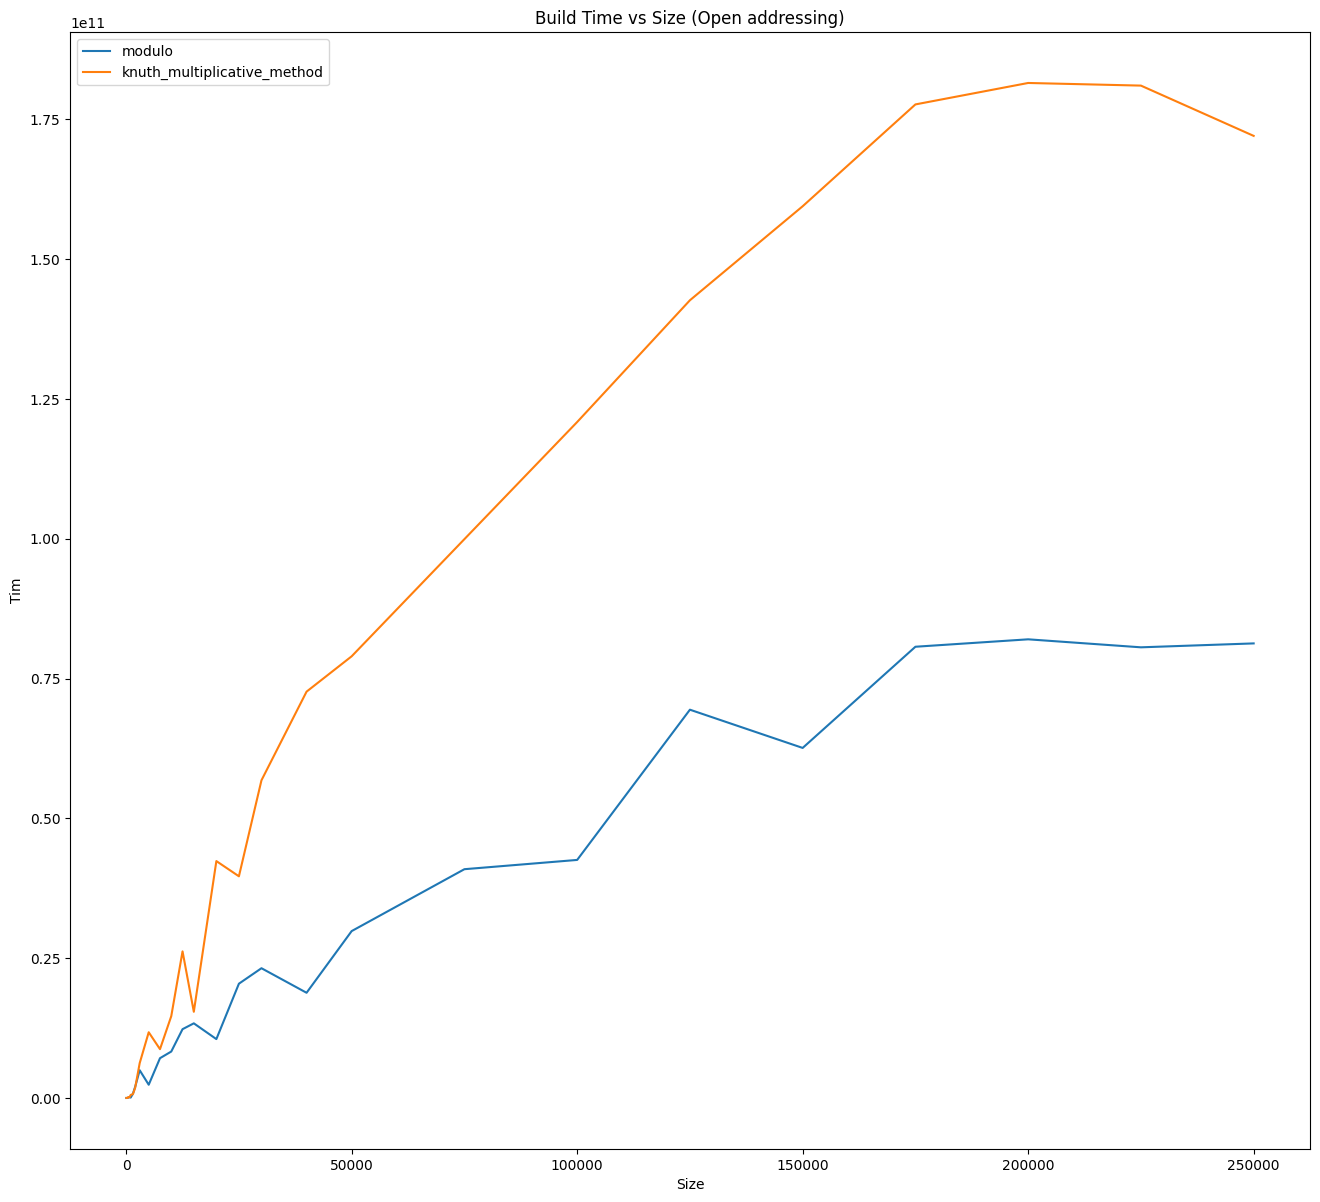

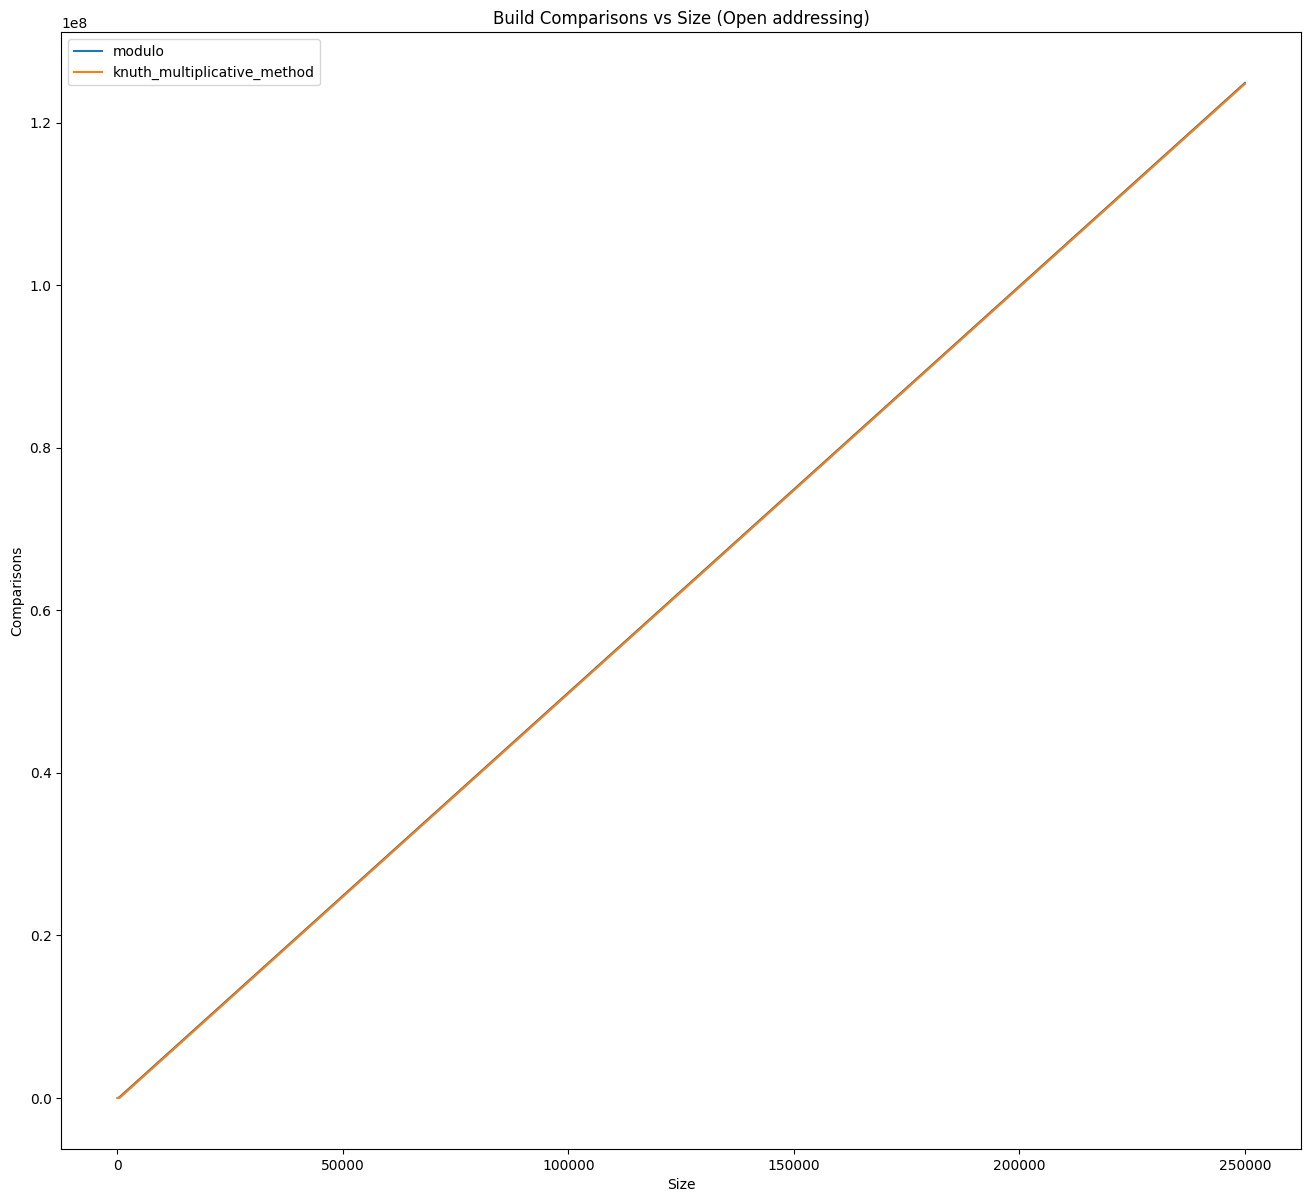

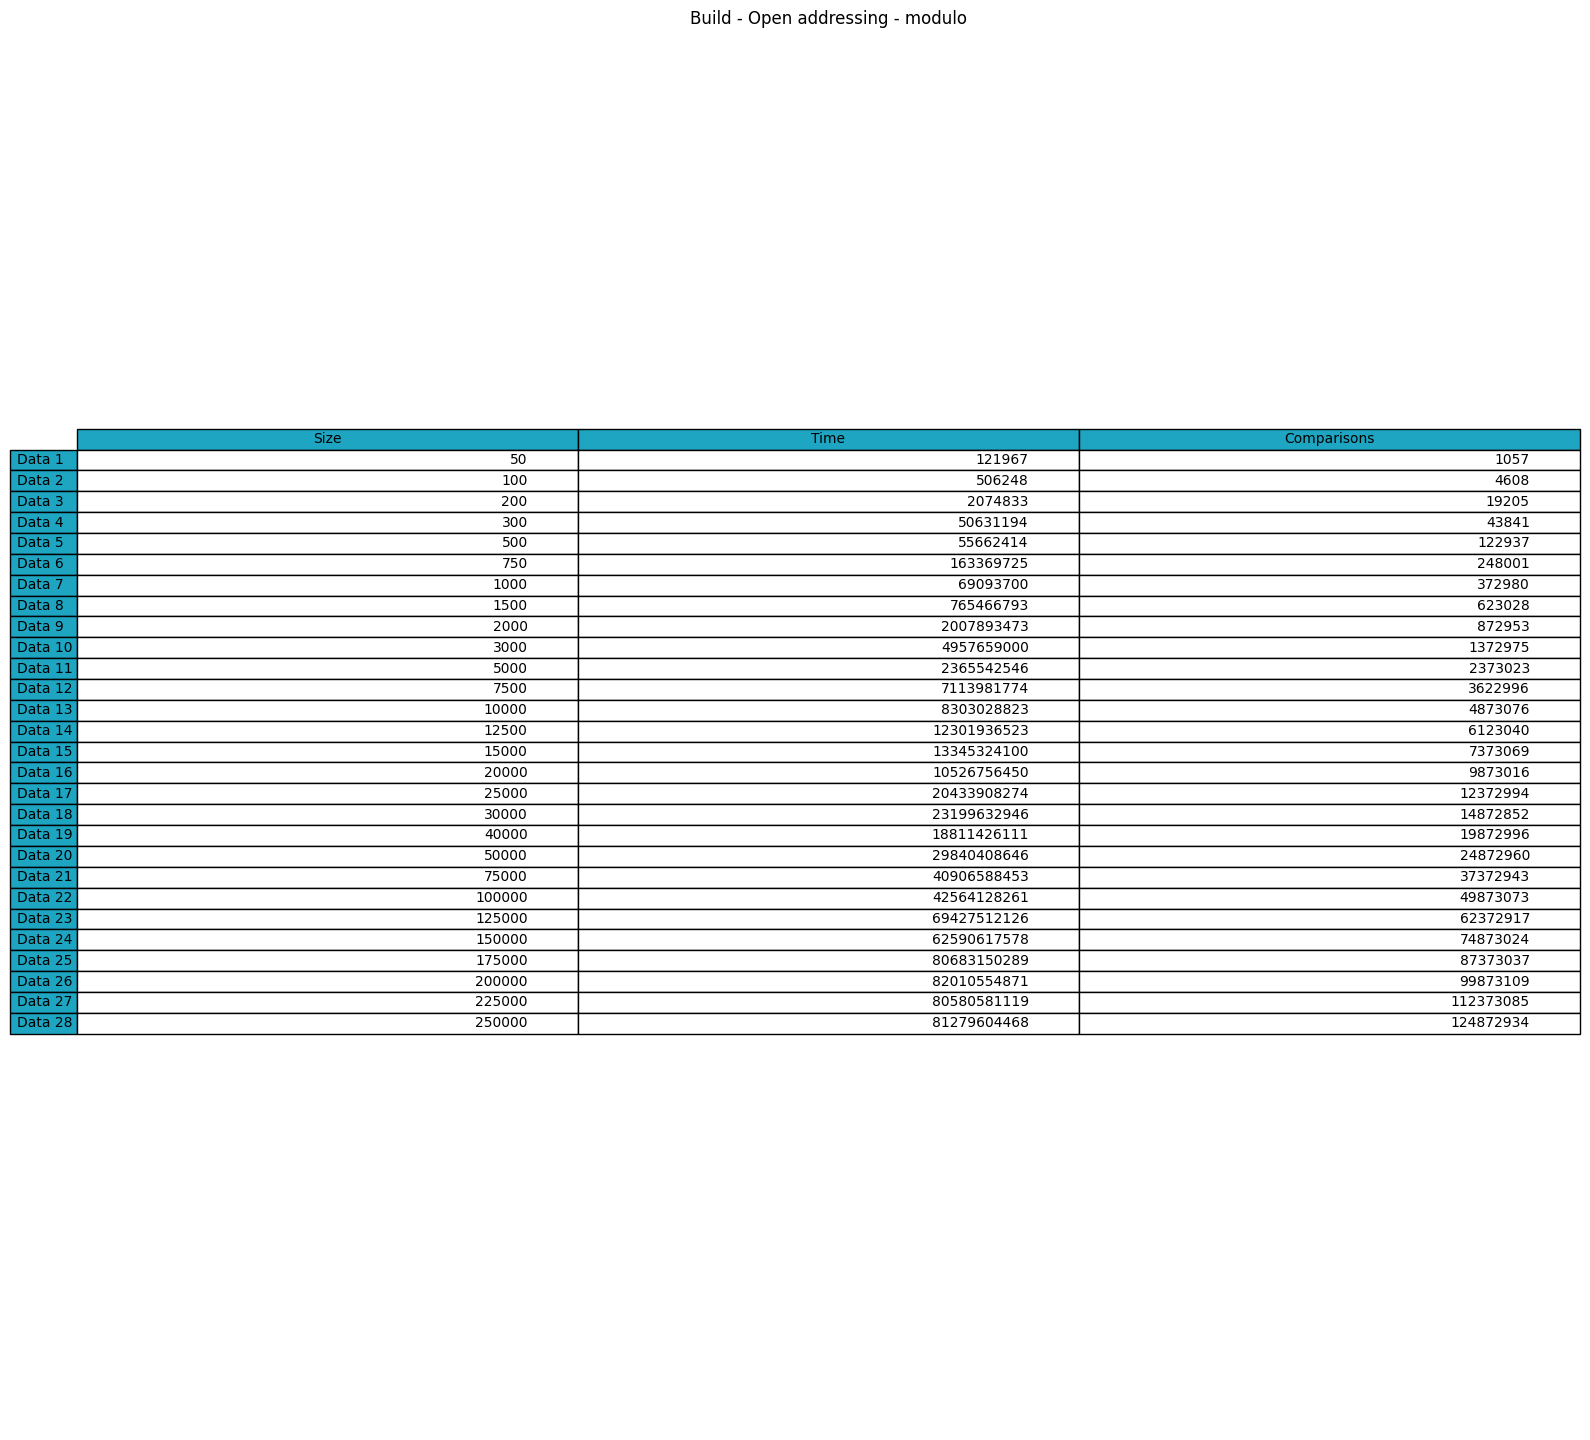

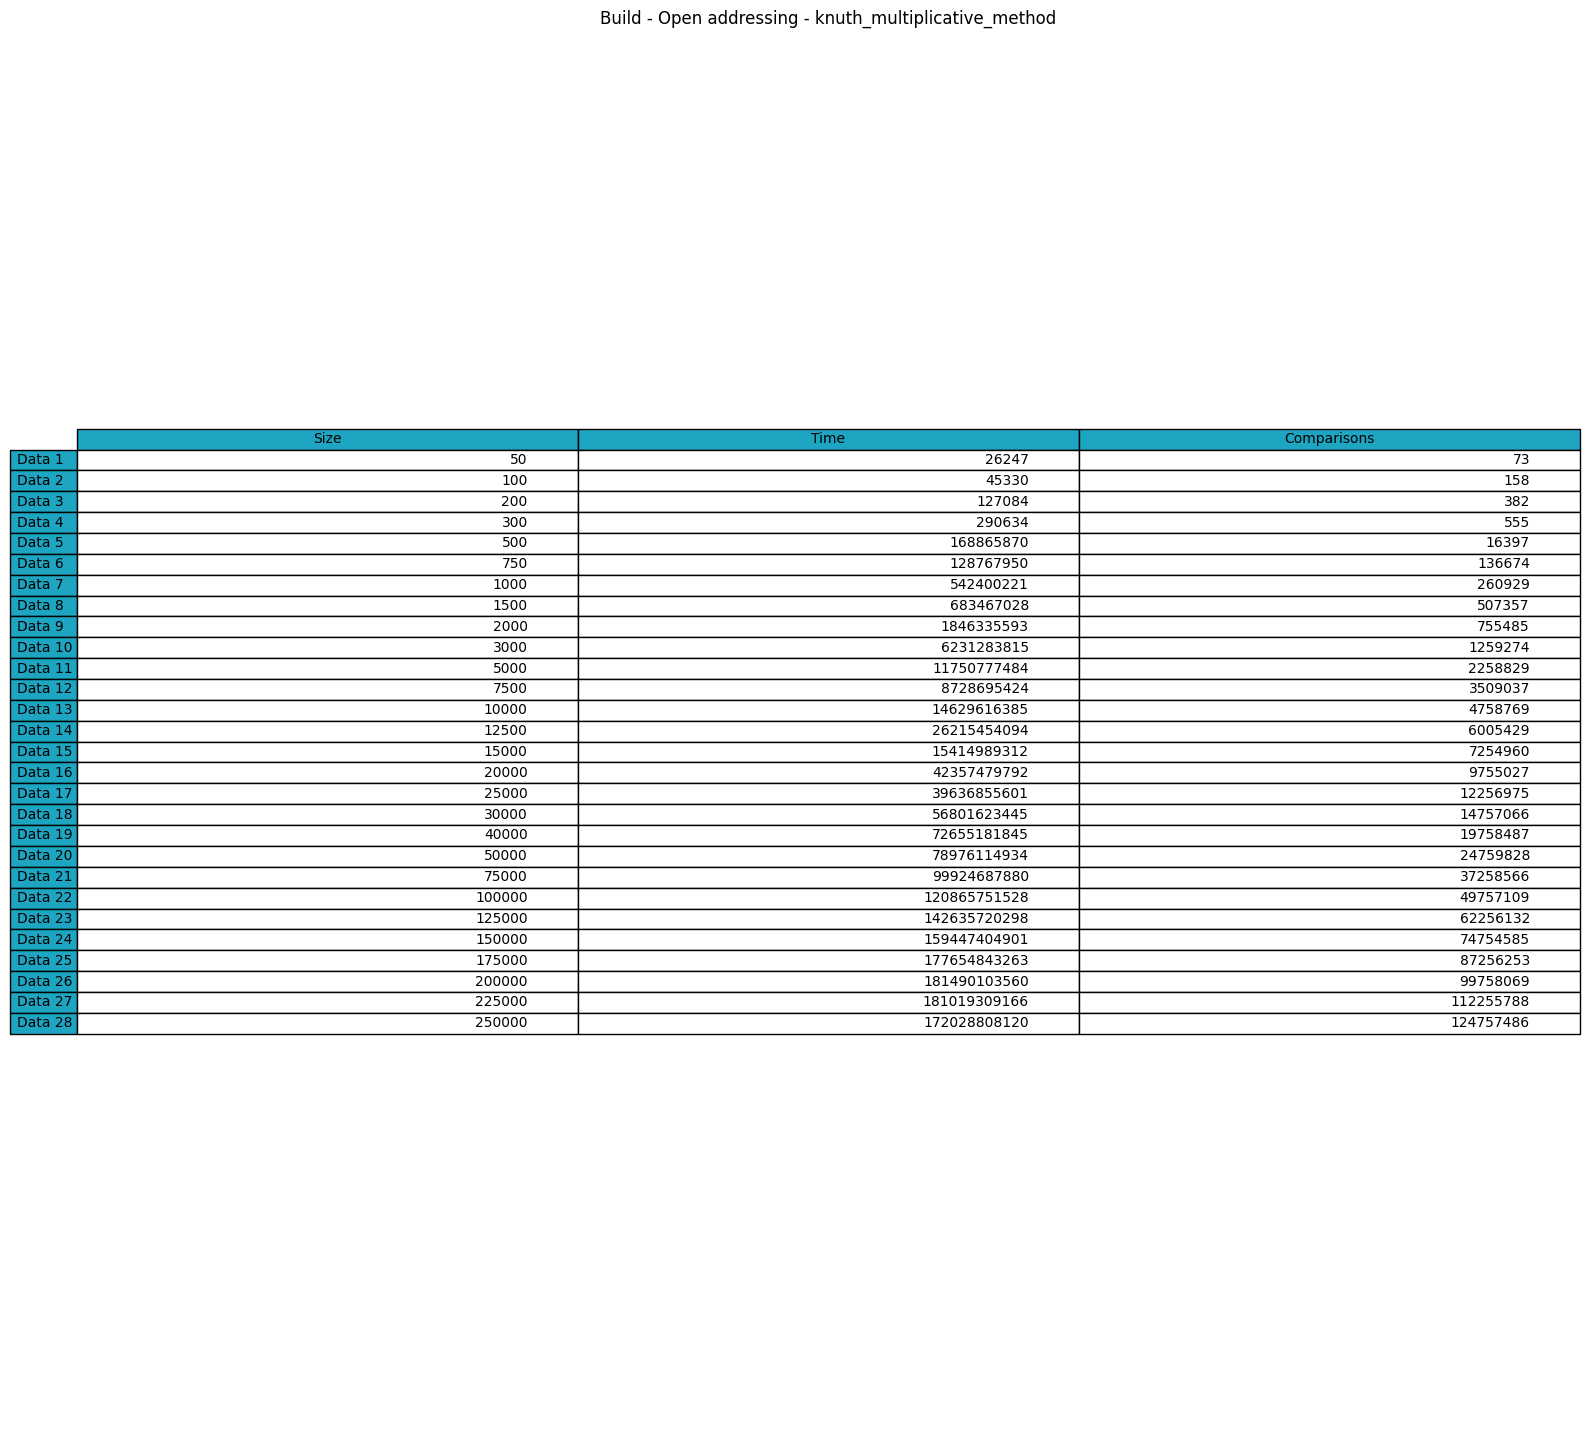

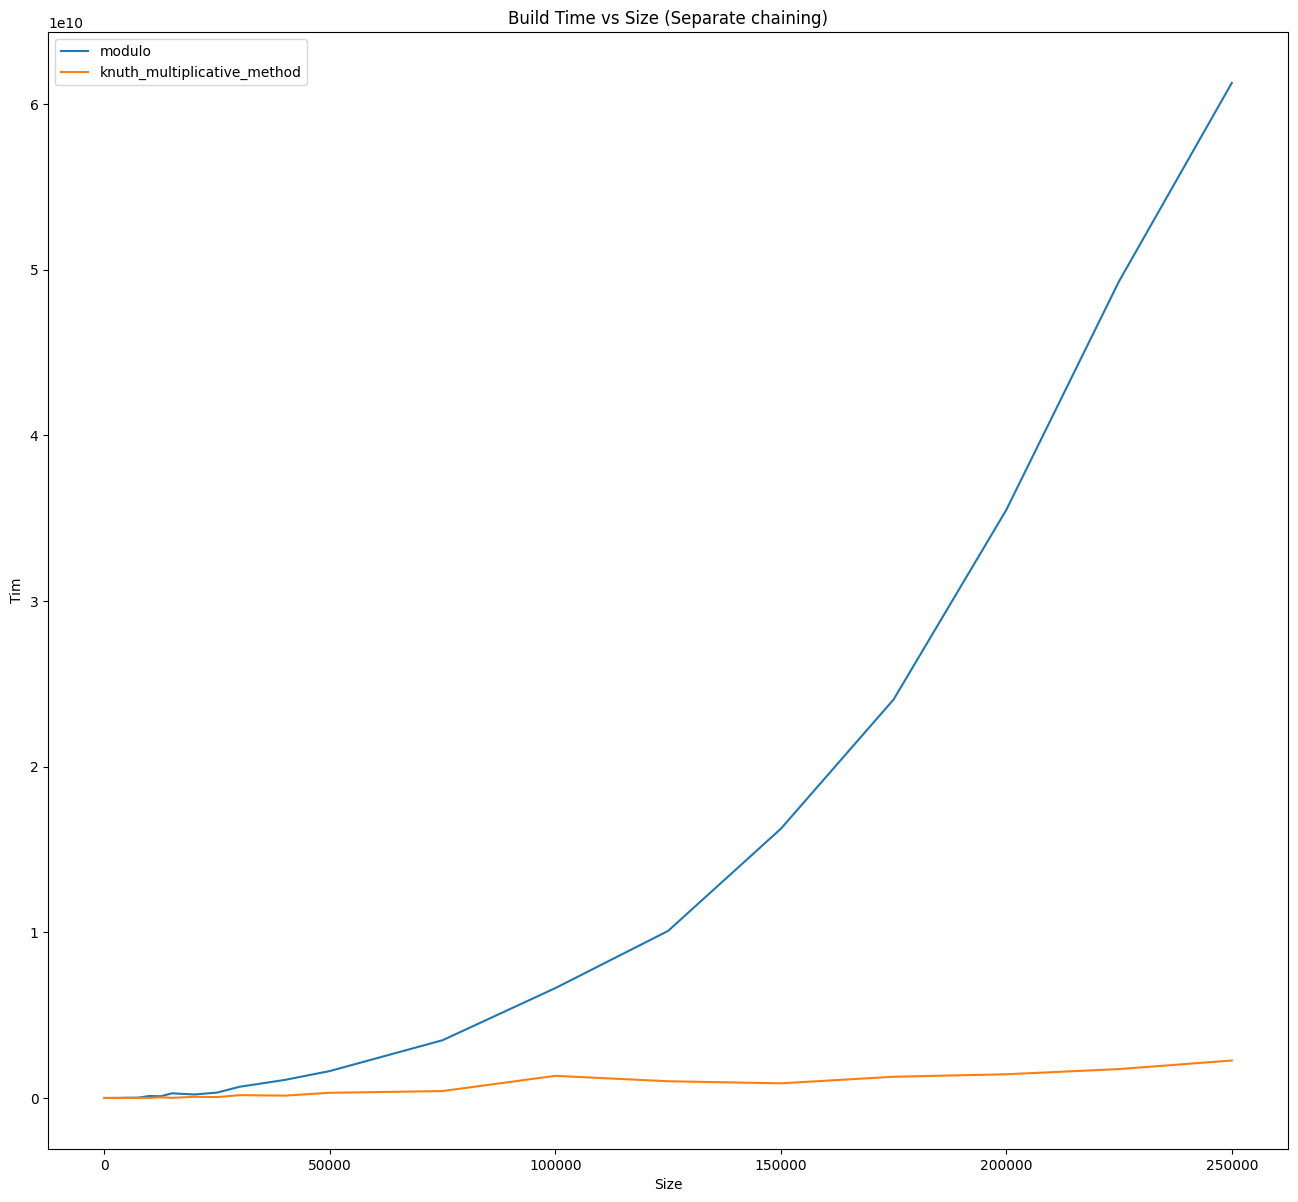

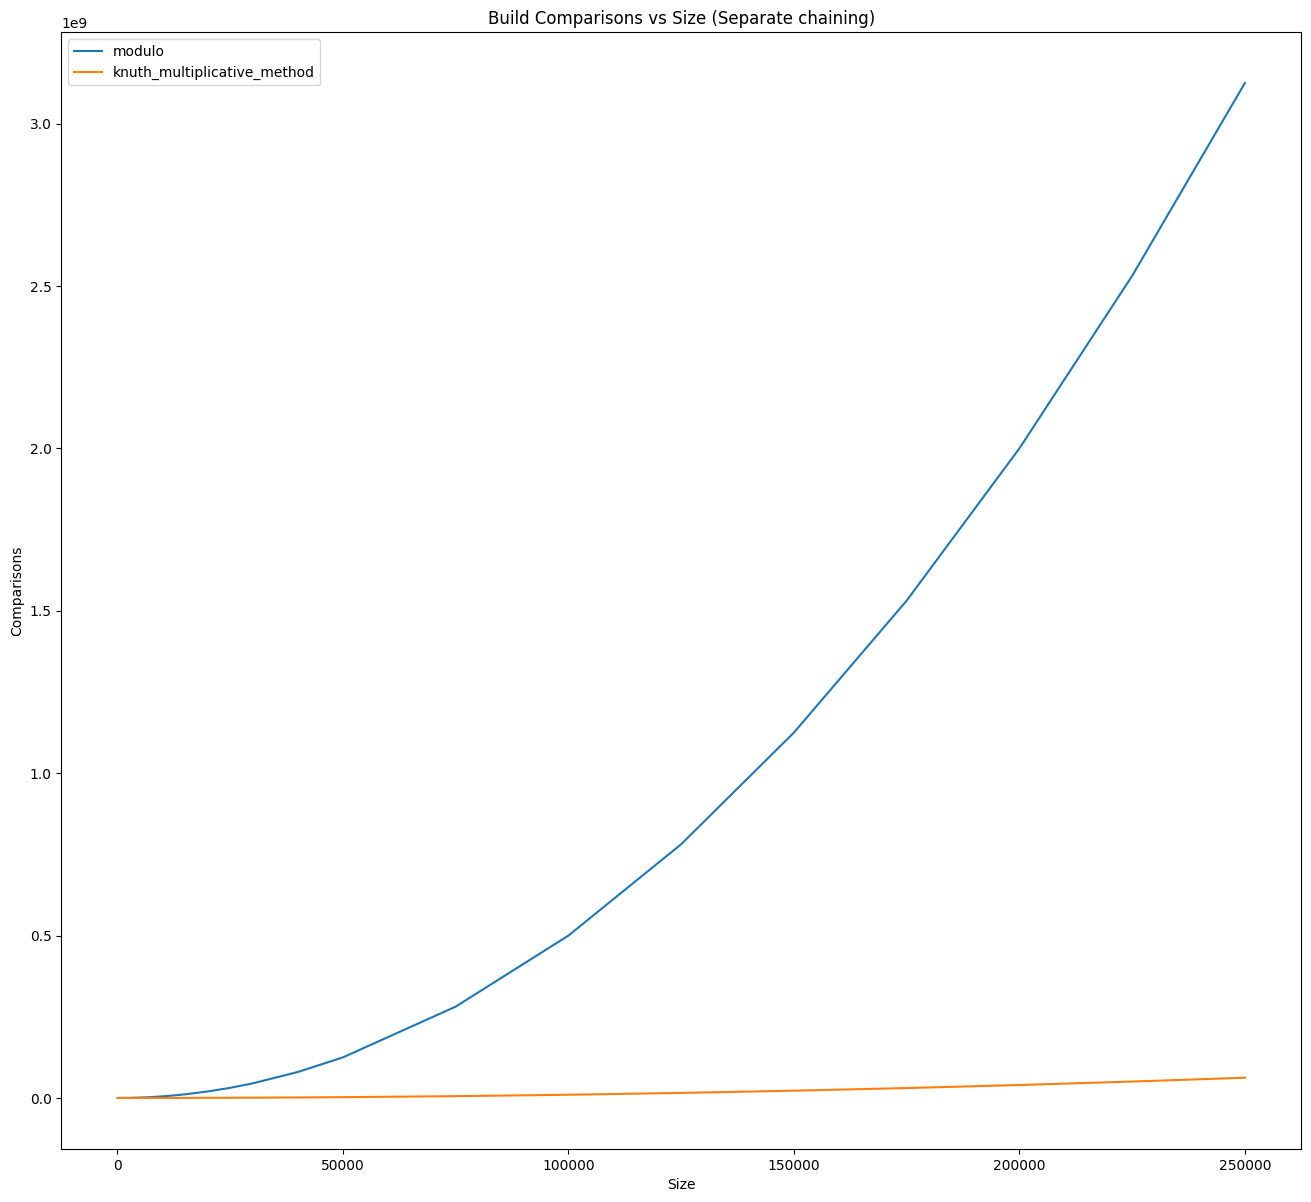

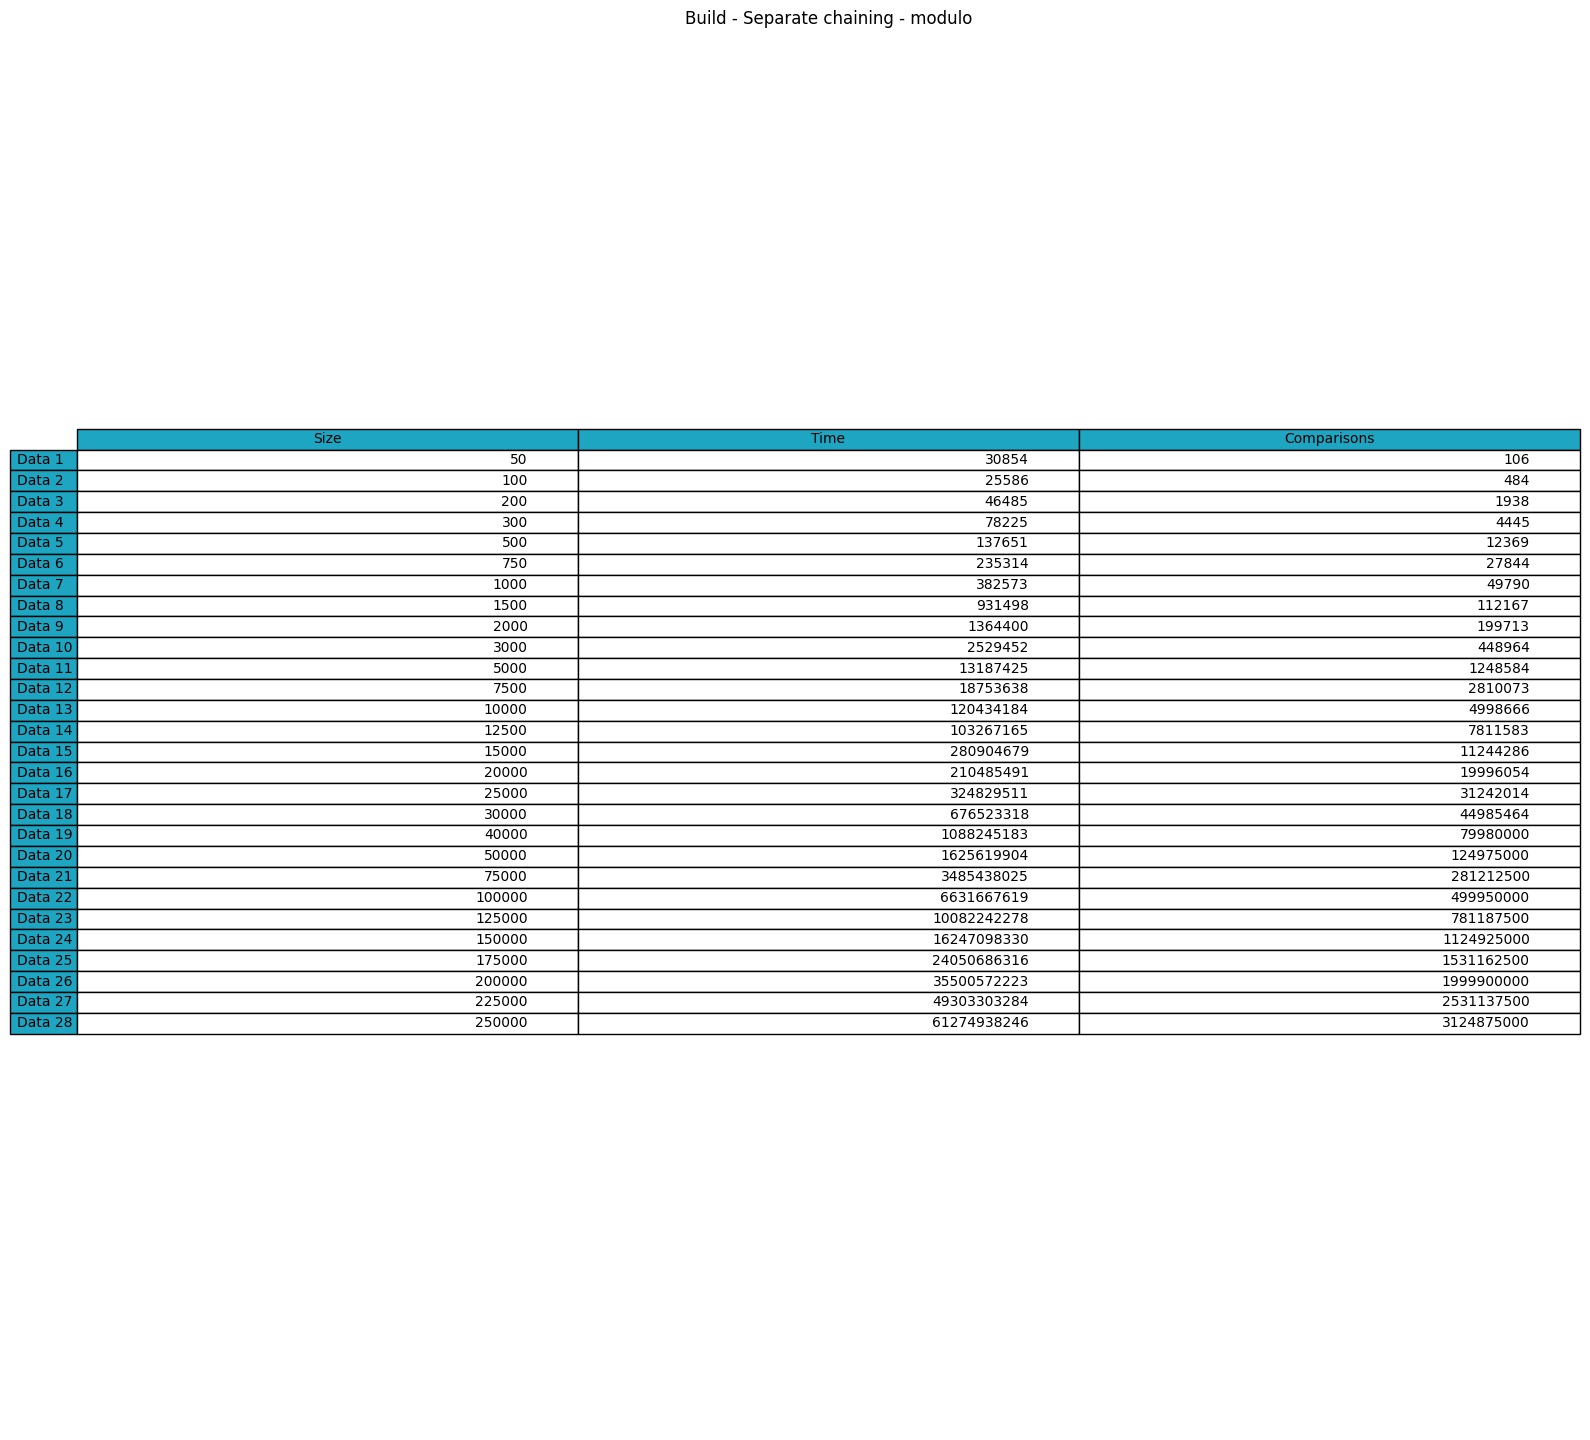

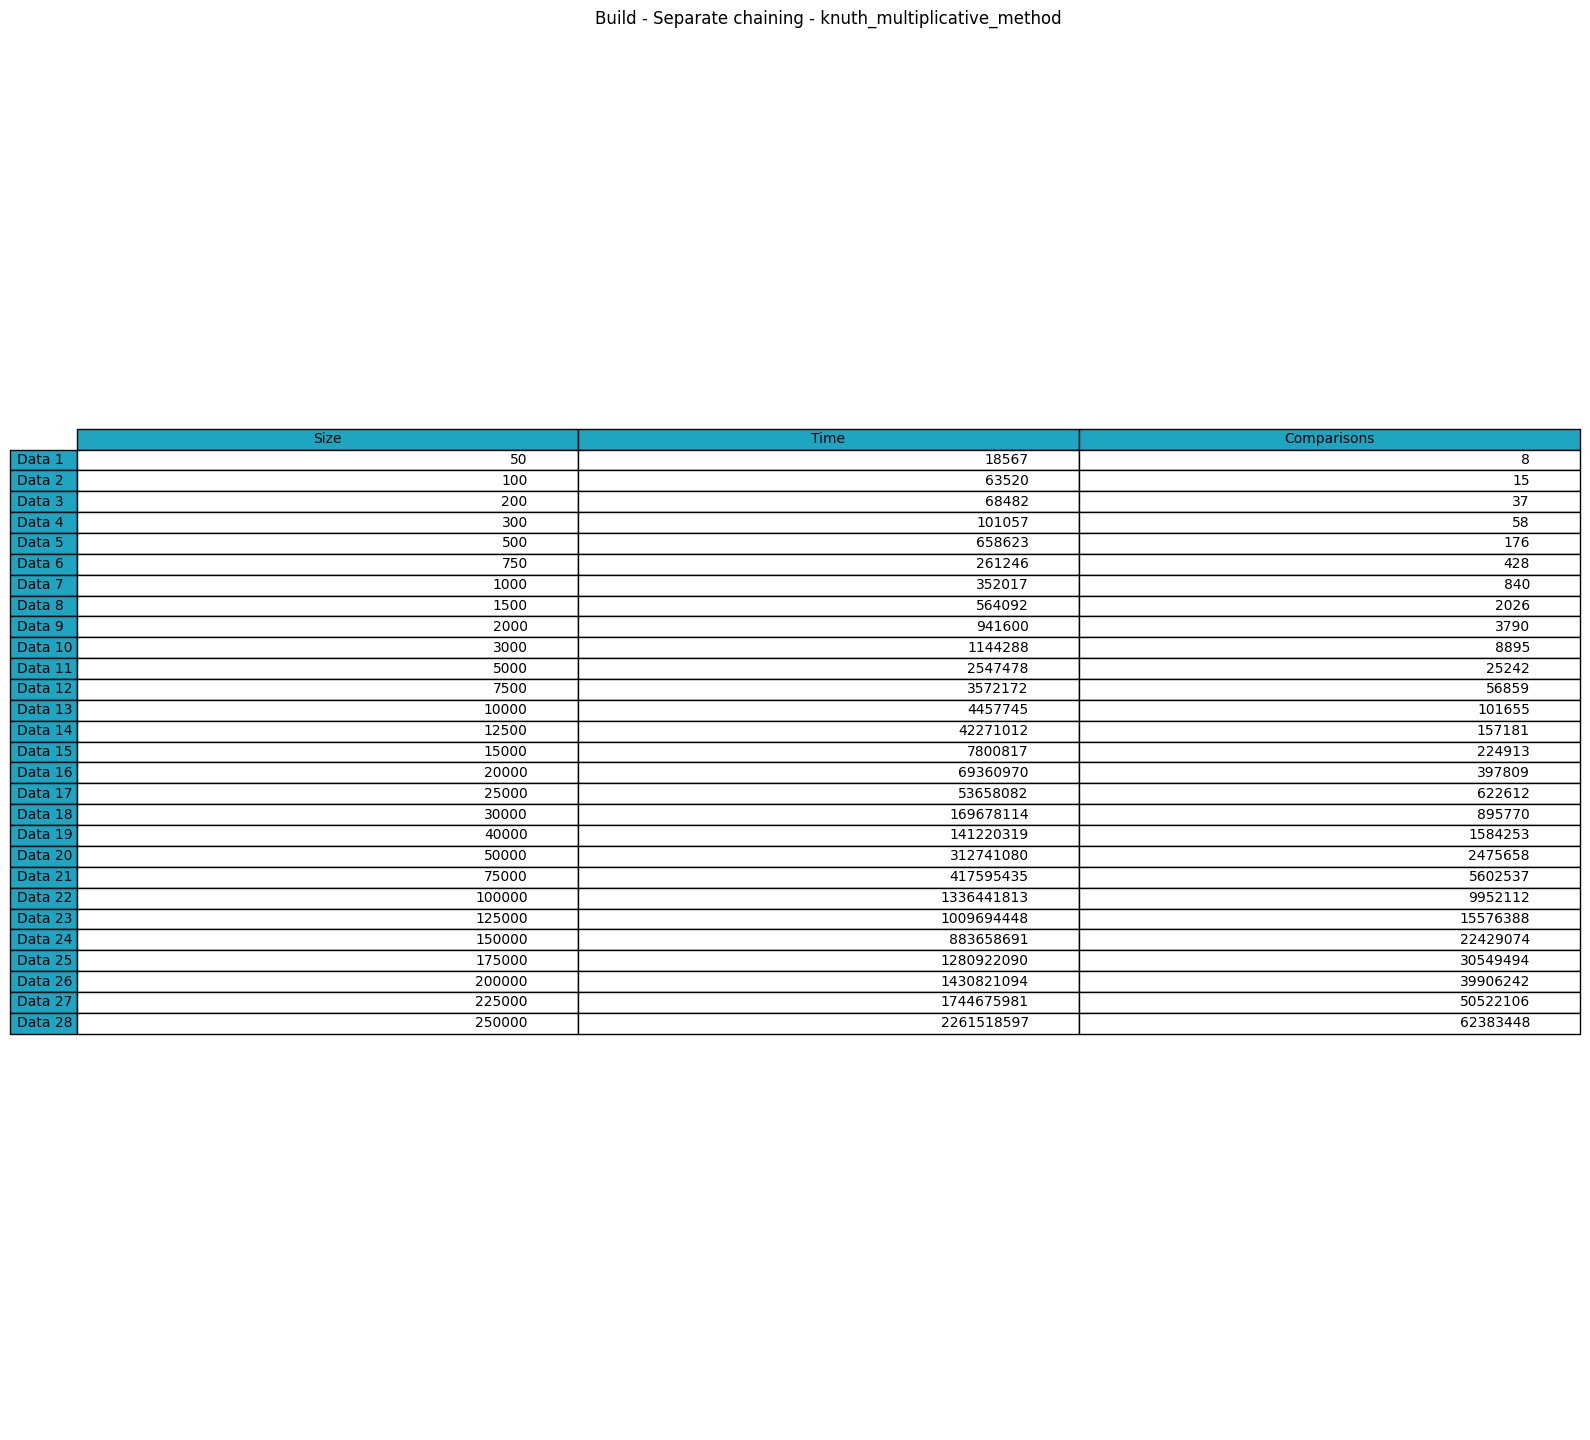

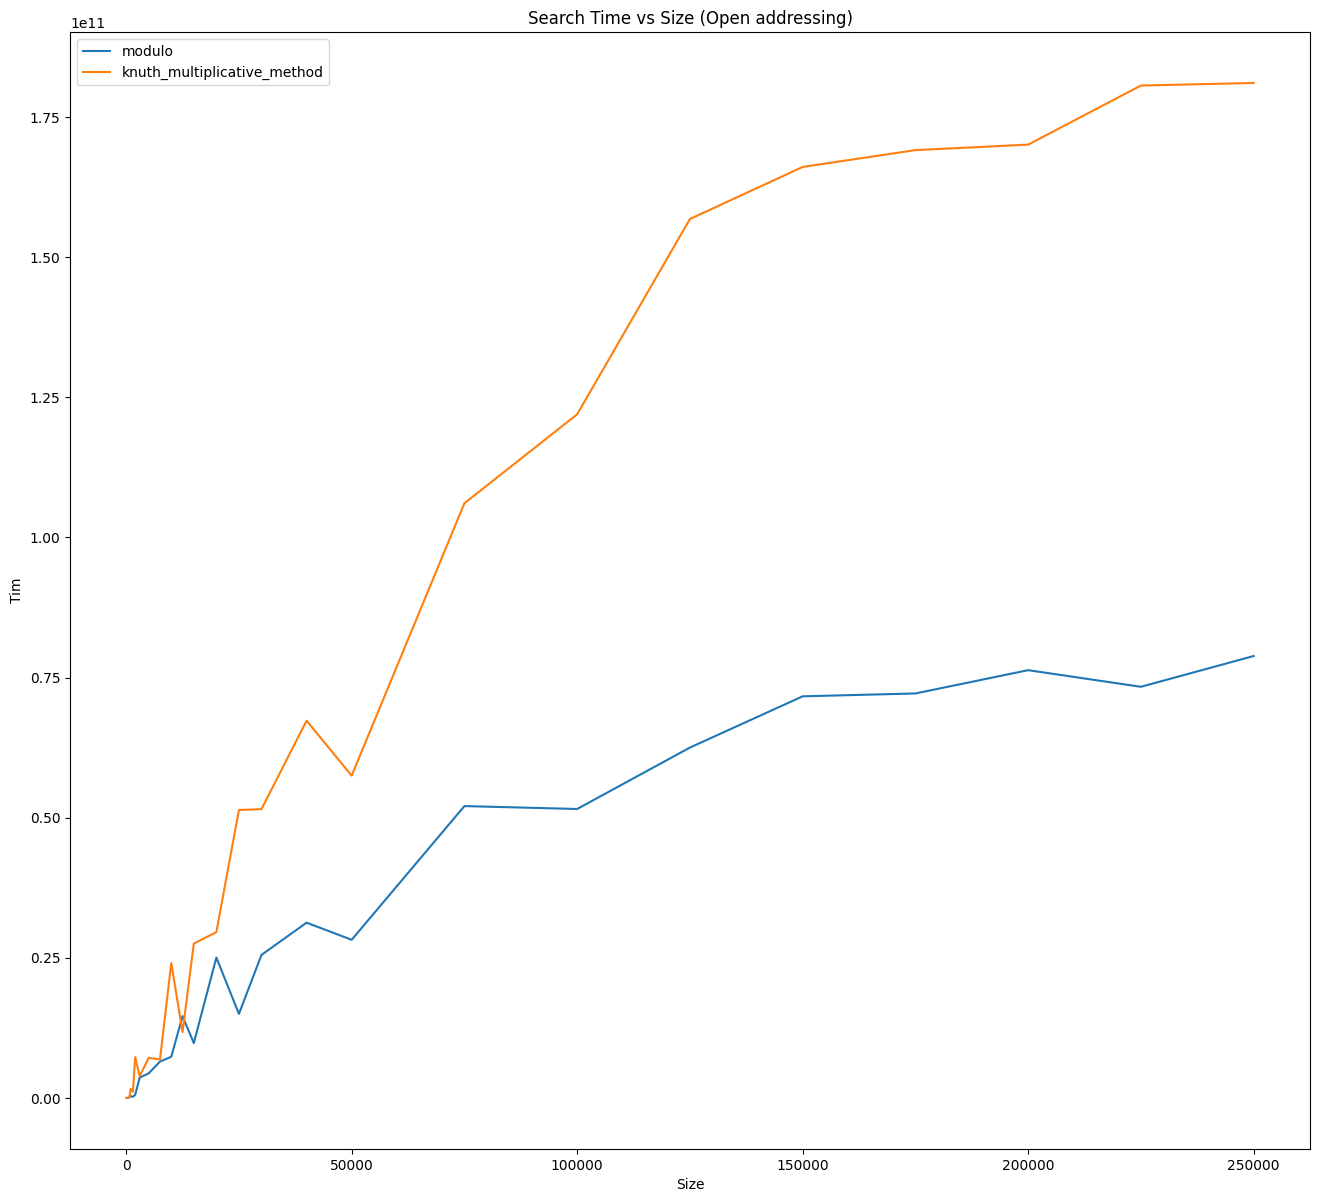

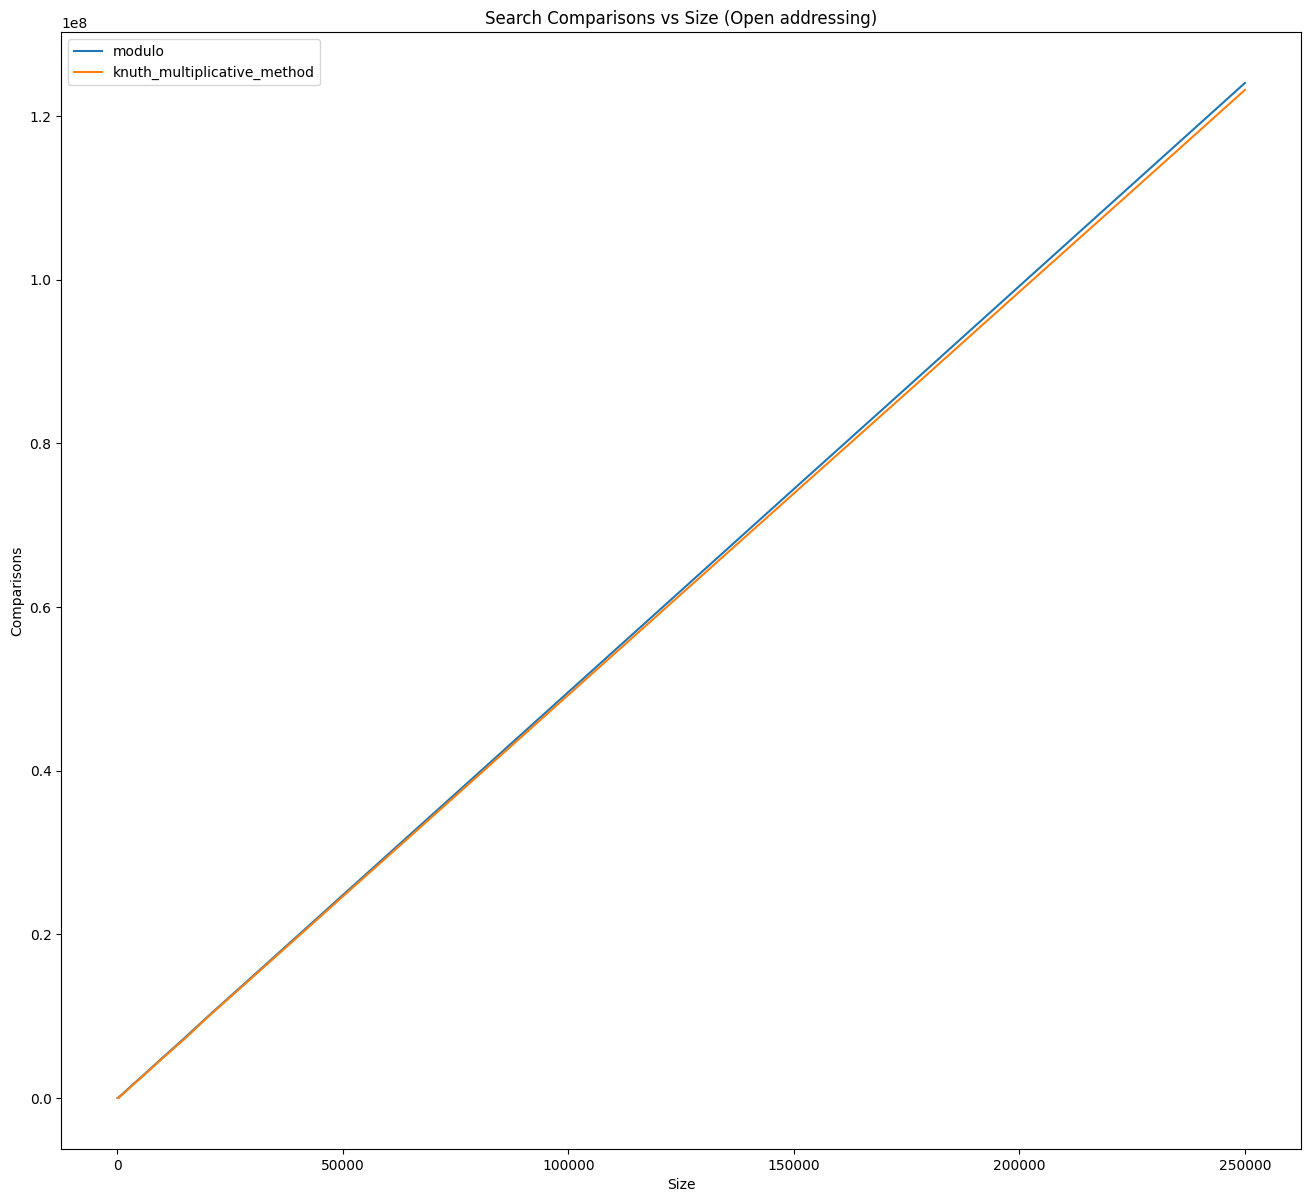

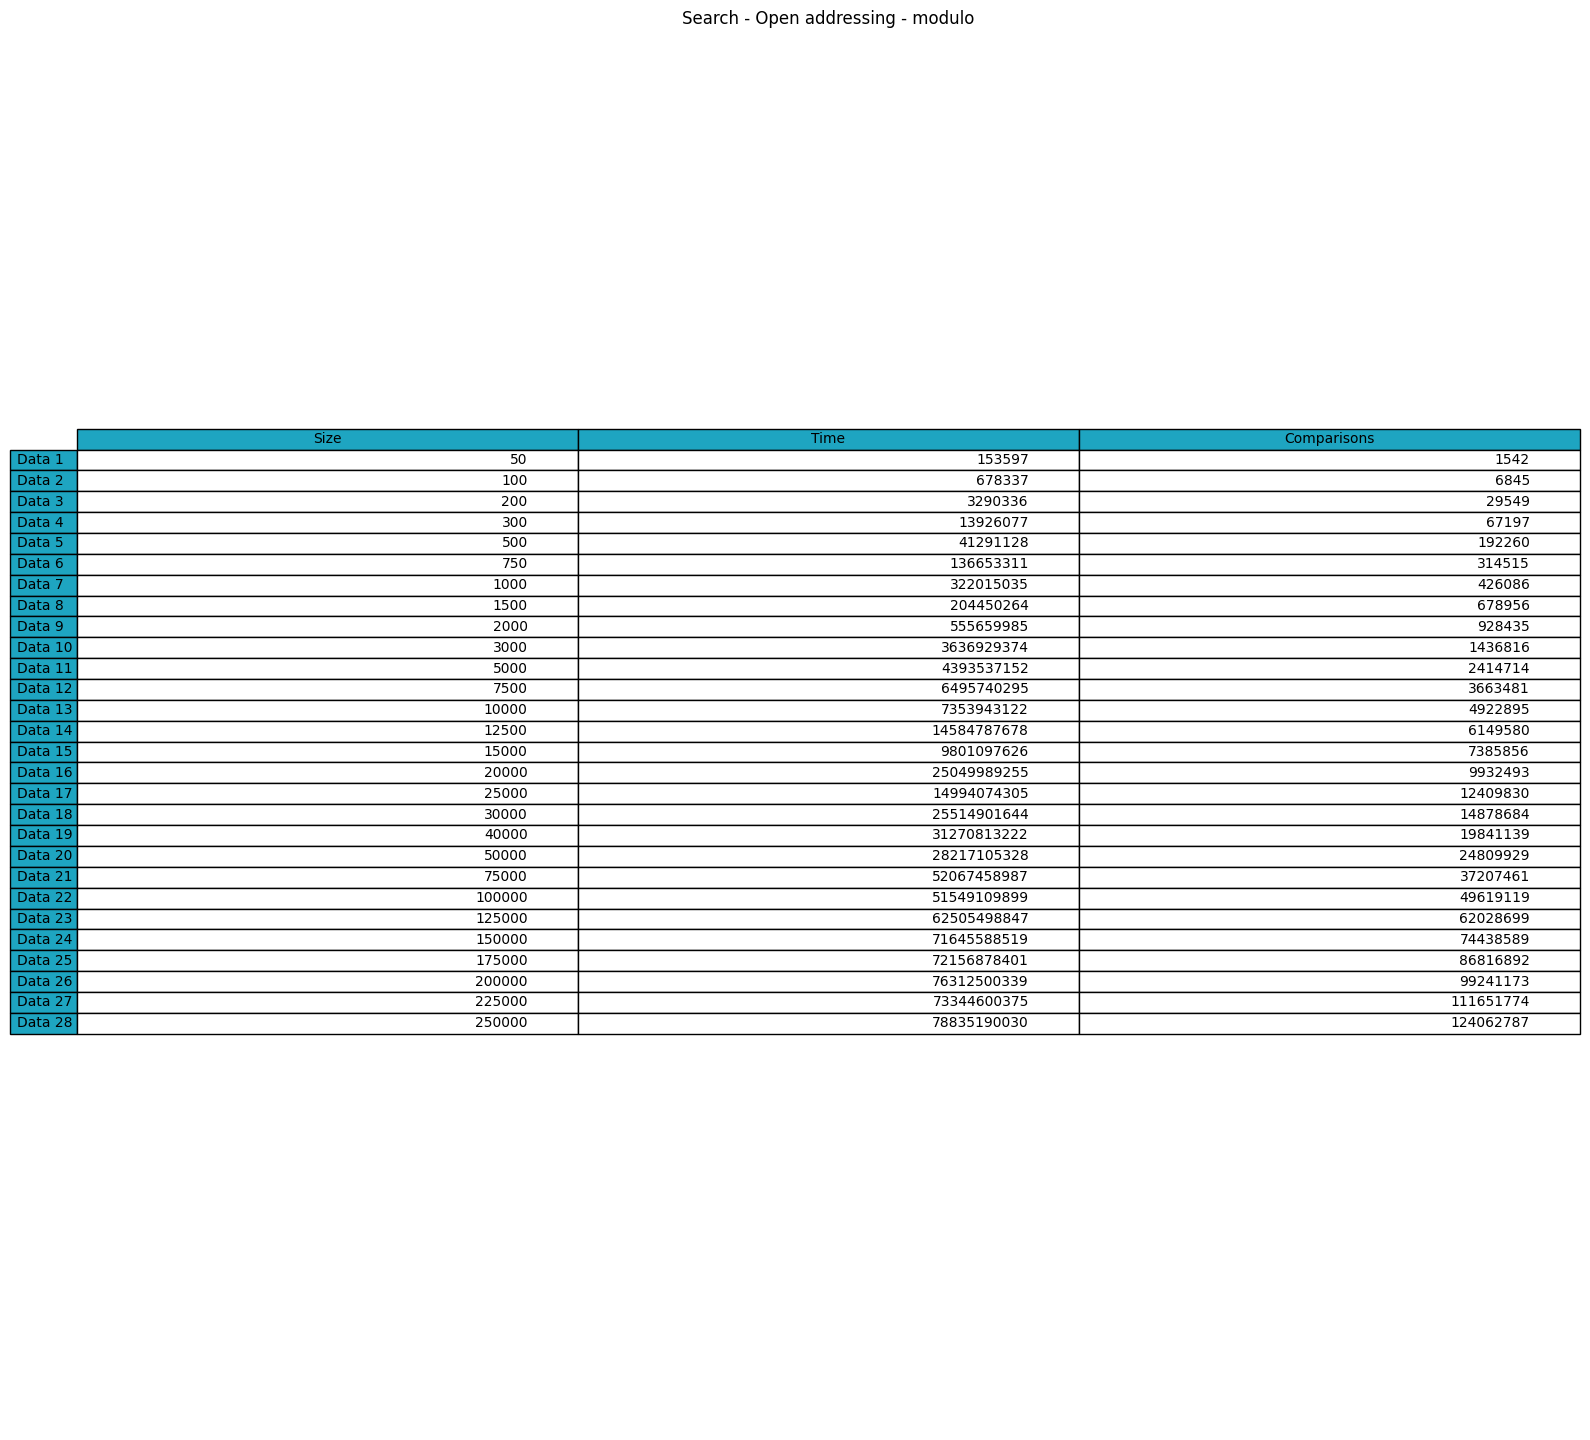

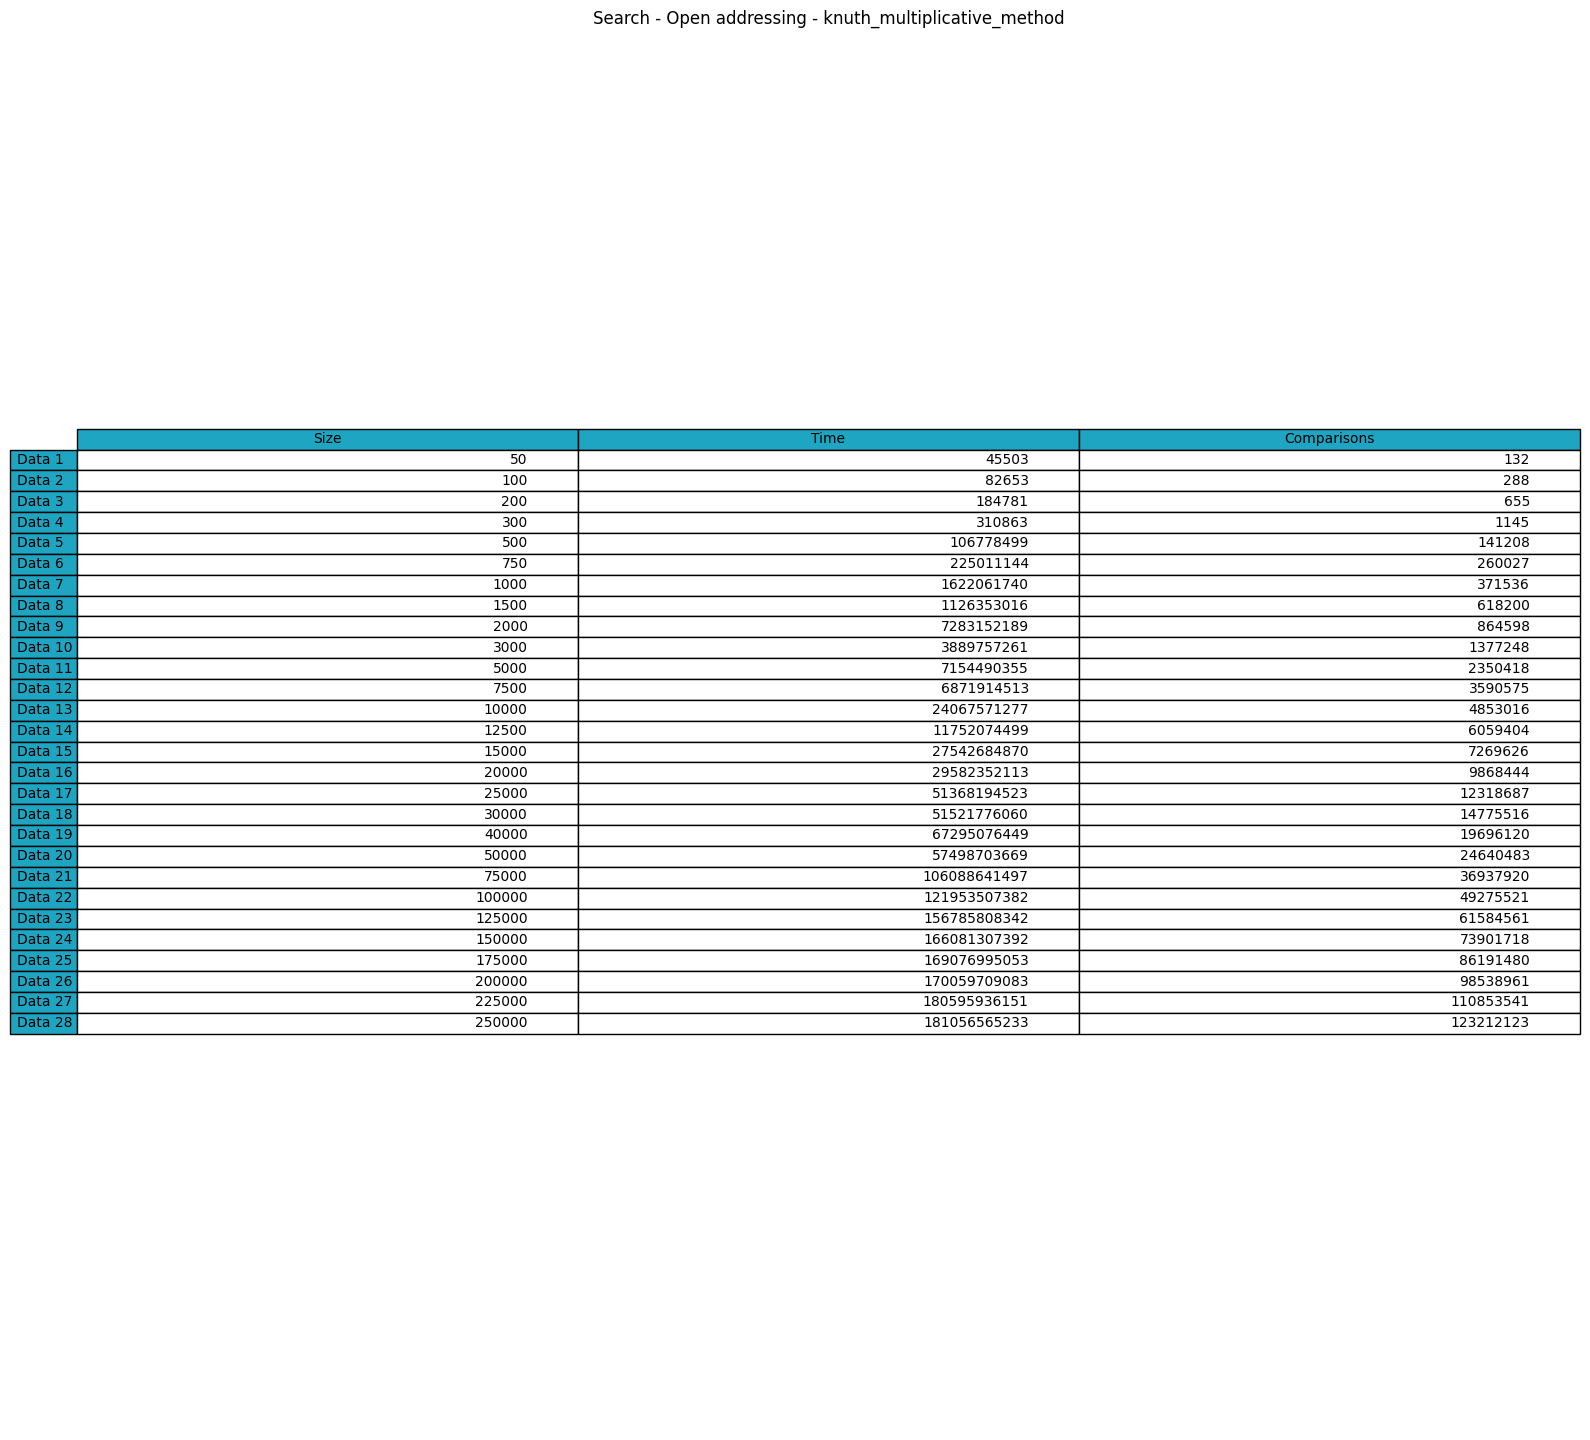

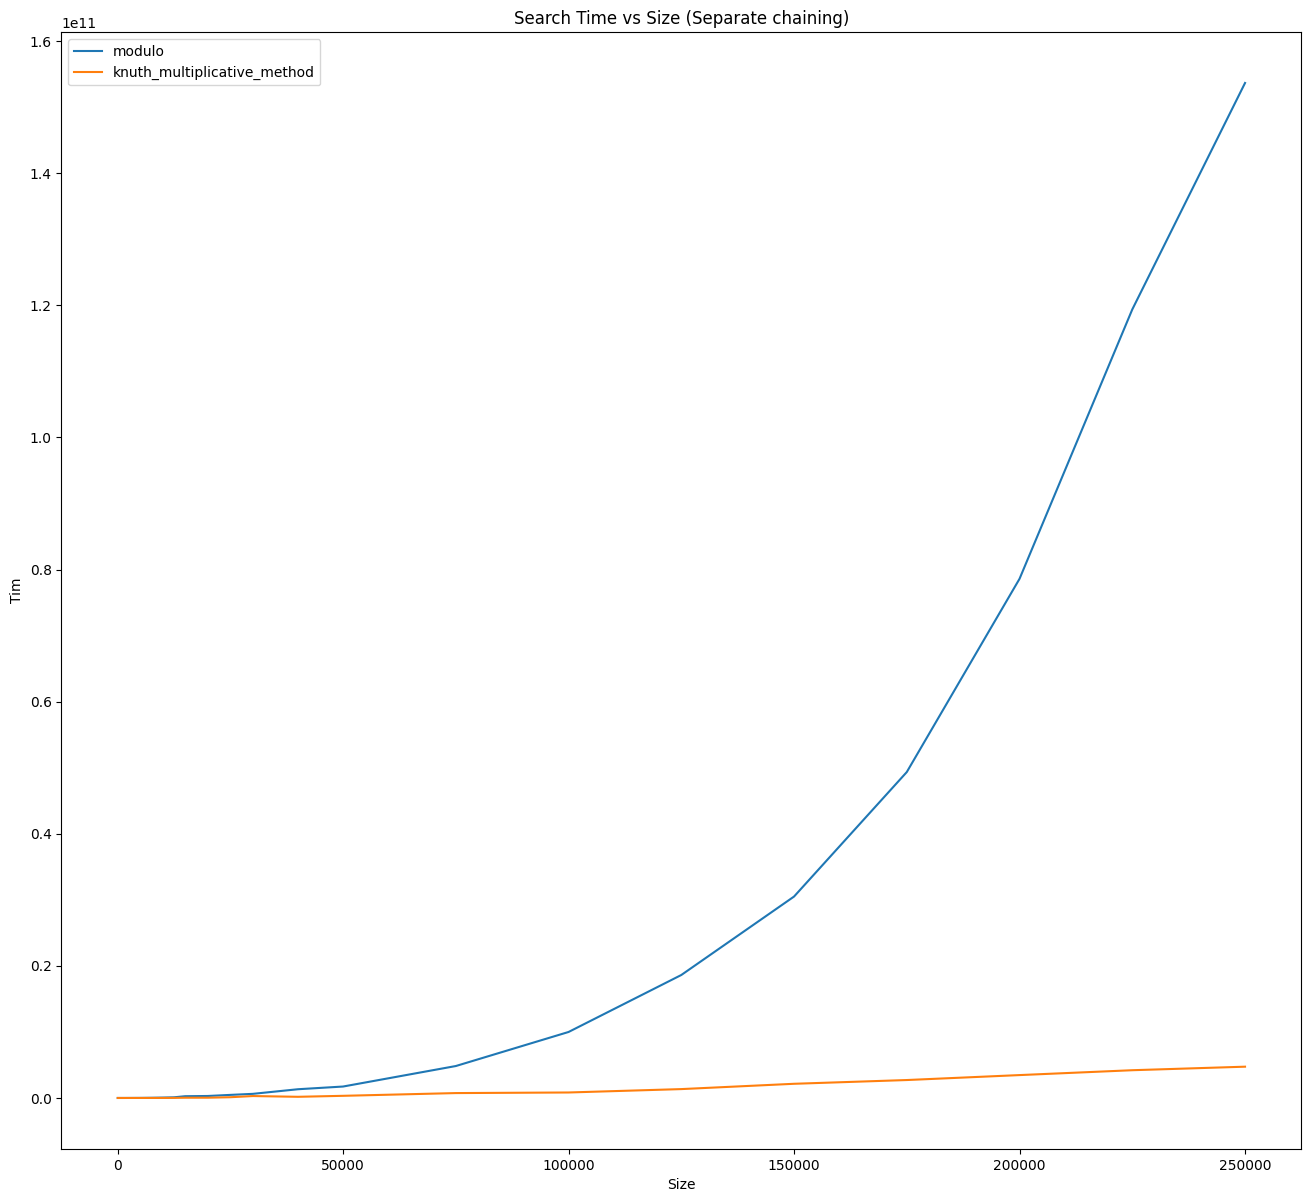

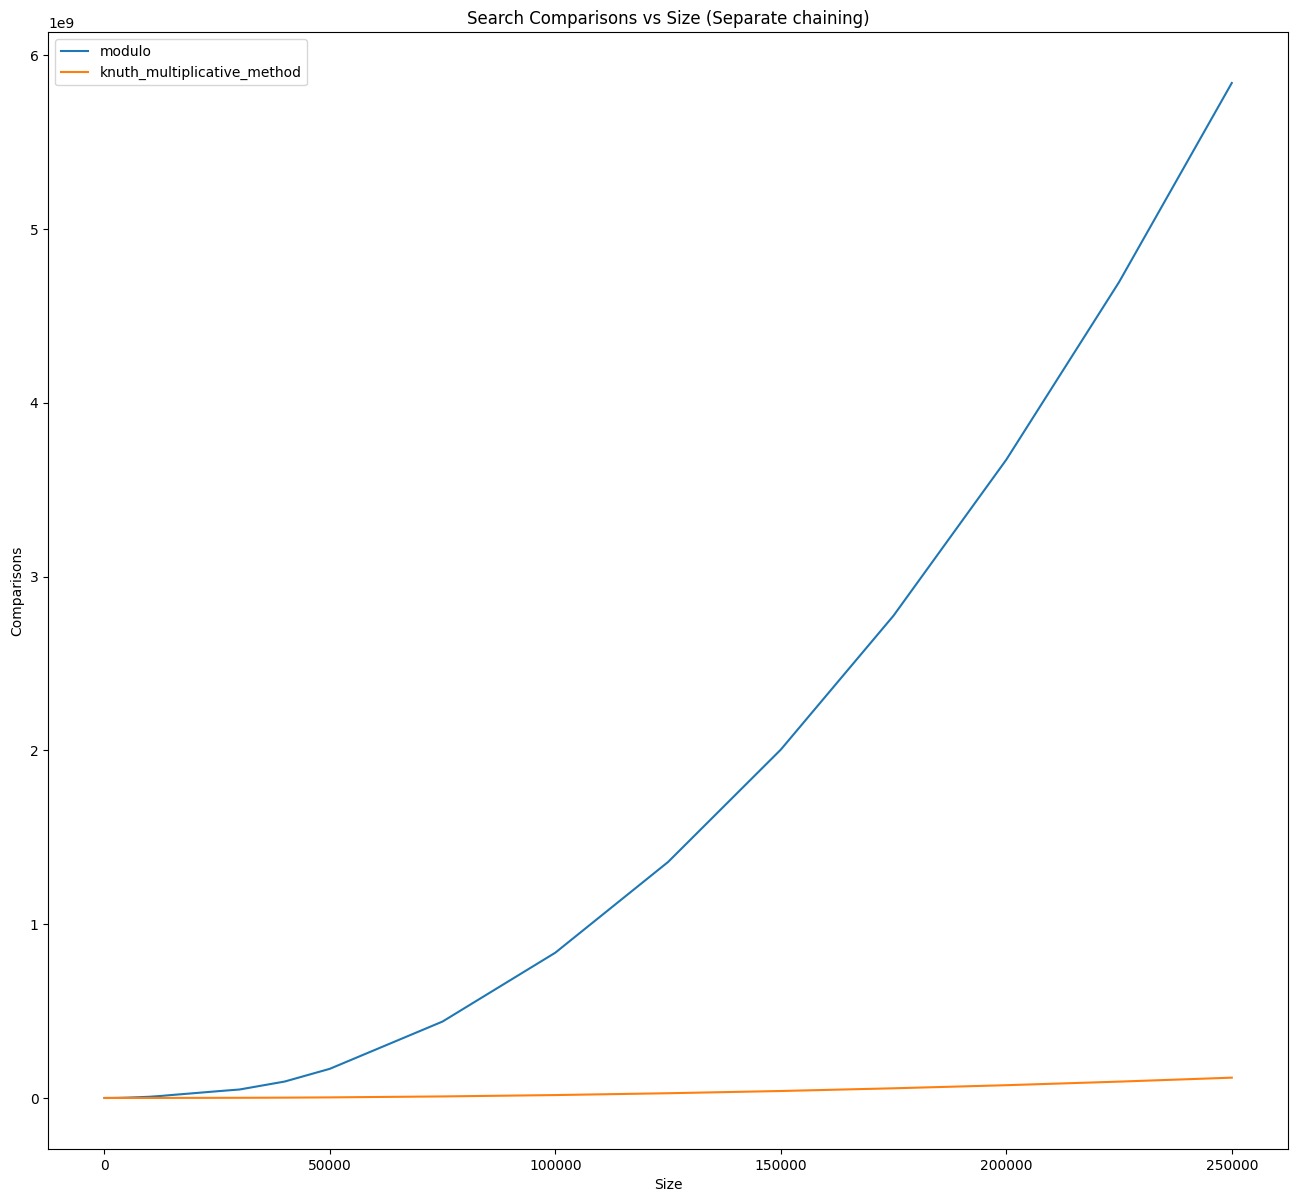

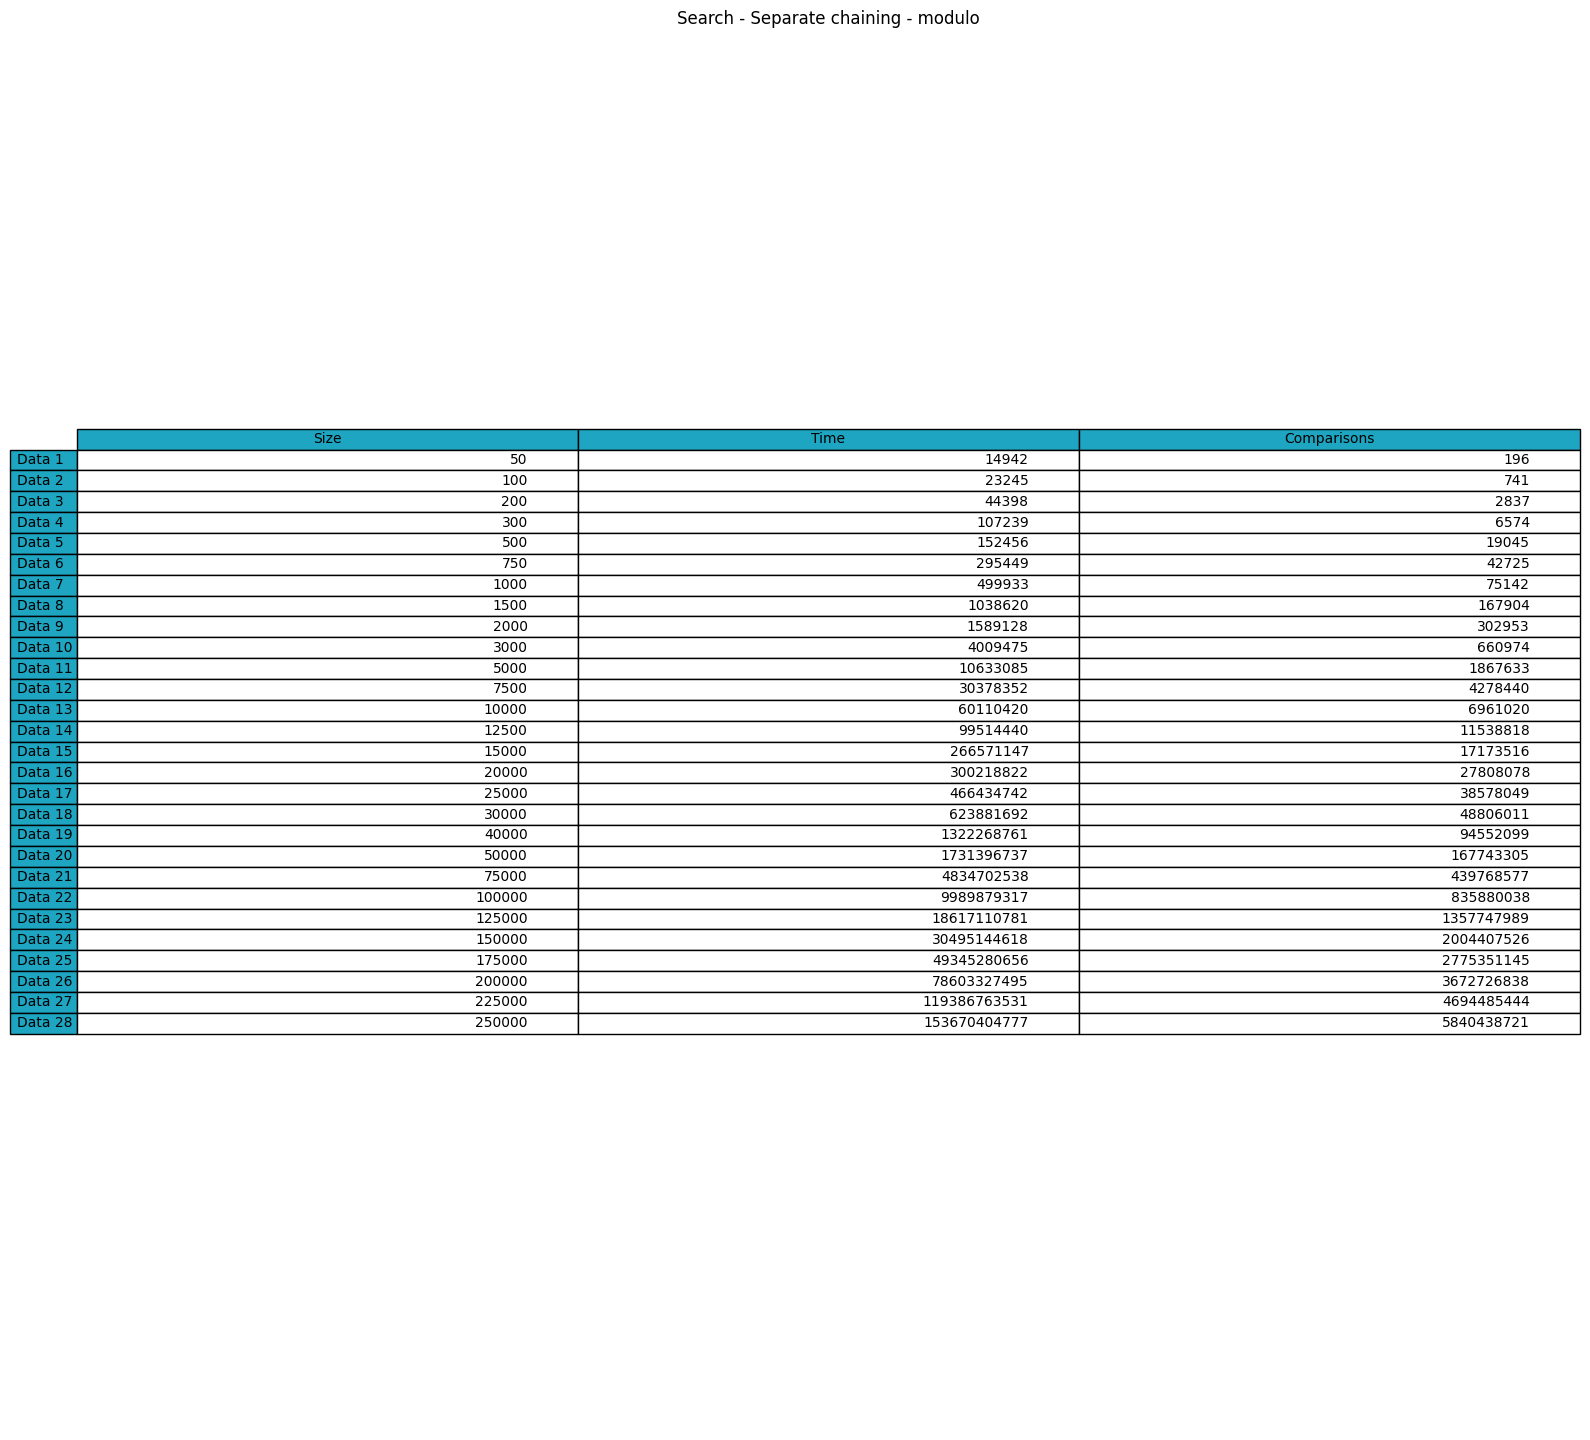

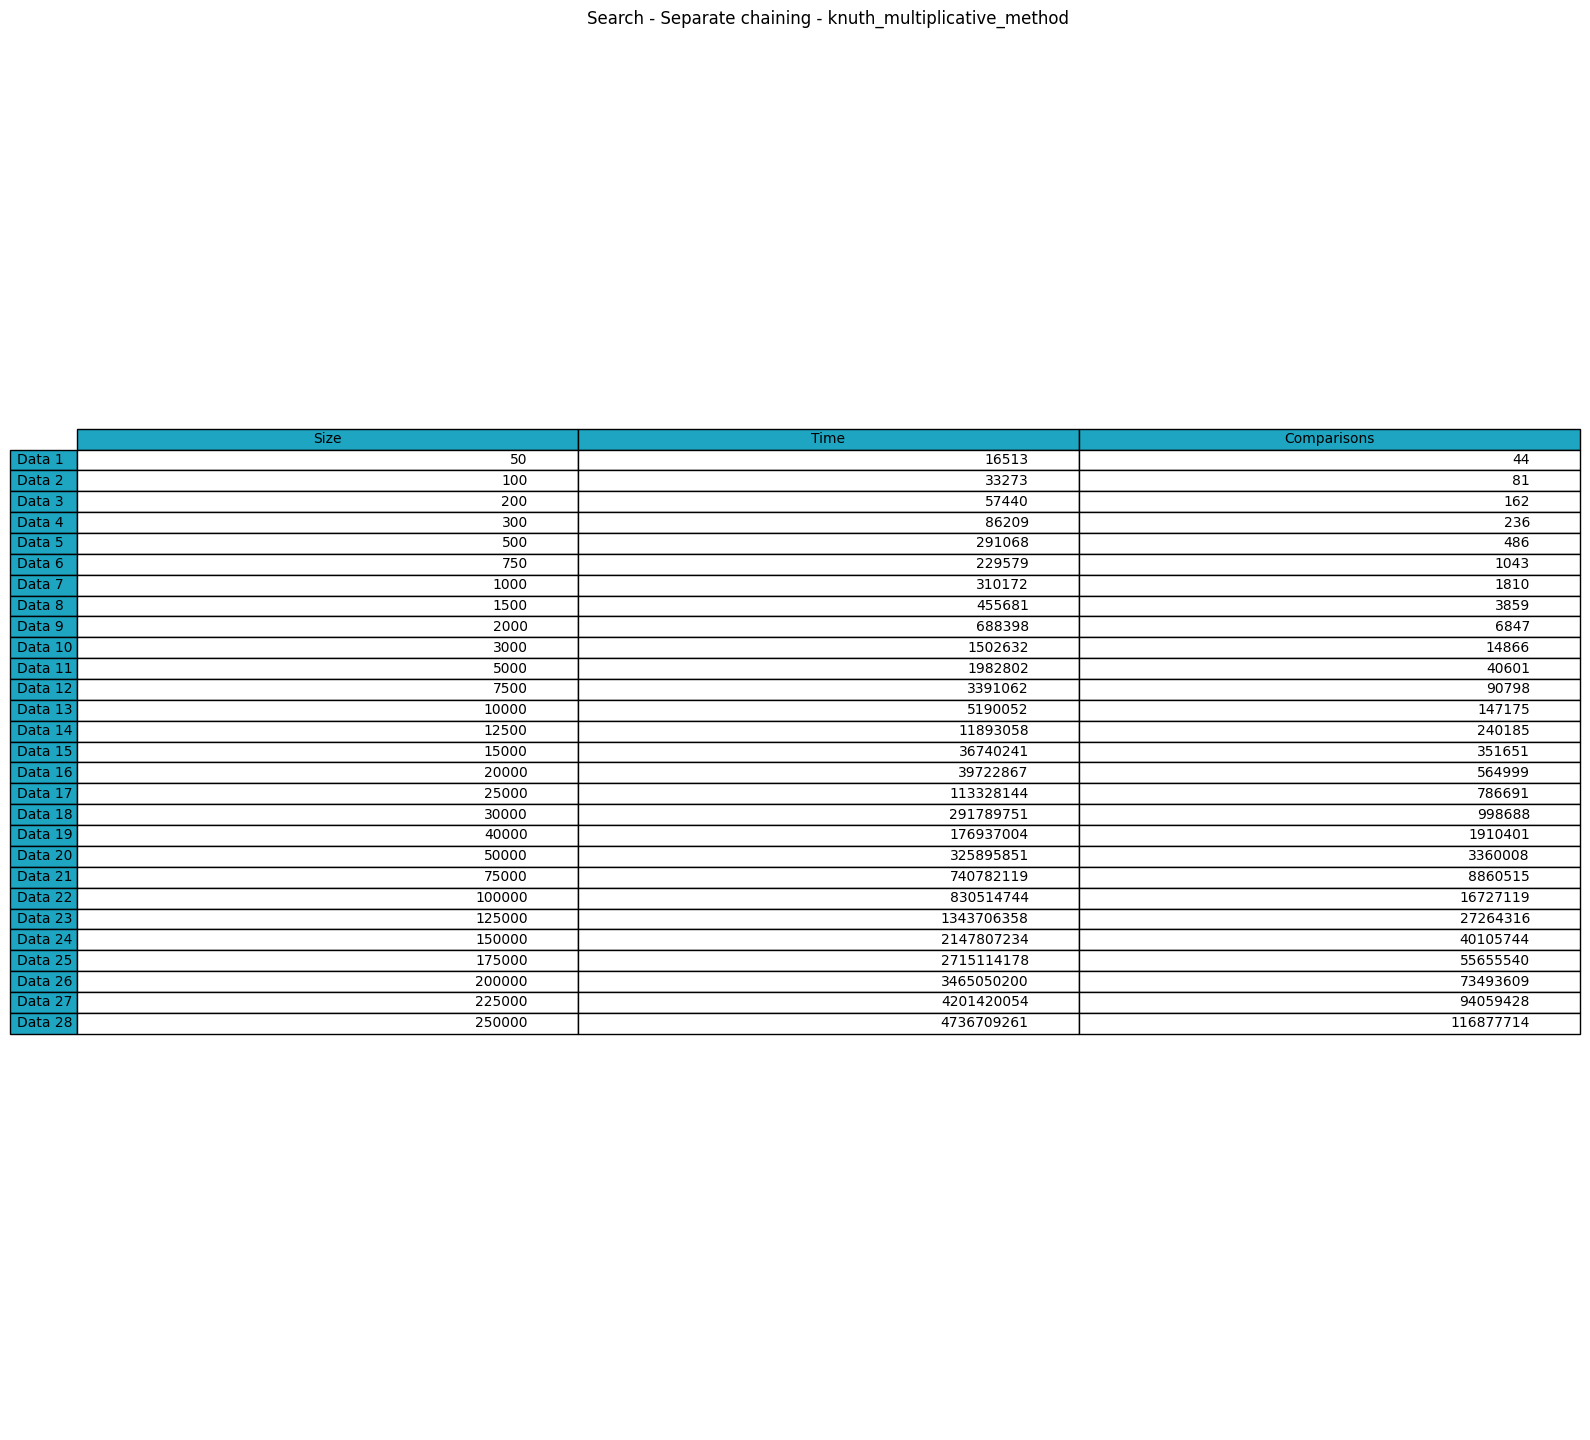

In [6]:
def plot_results(output: Dict[str, Dict[str, Dict[str, List[Dict[str,
                                                                 Any]]]]]):
    for operation in output:
        for table_type in output[operation]:
            # Collect data for all hash functions to plot them in a single chart
            x_values_list = []
            y_time_values_list = []
            y_comparisons_values_list = []

            for hash_func_name in output[operation][table_type]:
                x_values = [
                    entry["size"]
                    for entry in output[operation][table_type][hash_func_name]
                ]
                time_values = [
                    entry["time"]
                    for entry in output[operation][table_type][hash_func_name]
                ]
                comparisons_values = [
                    entry["comparisons"]
                    for entry in output[operation][table_type][hash_func_name]
                ]

                x_values_list.append(x_values)
                y_time_values_list.append(time_values)
                y_comparisons_values_list.append(comparisons_values)

            hash_func_names = list(hash_functions.keys())

            # Plot time vs size
            picoplot(
                f"{operation.capitalize()} Time vs Size ({table_type.replace('_', ' ').capitalize()})",
                x_values_list,
                y_time_values_list,
                hash_func_names,
                plt.cm.tab10.colors,  # Default matplotlib color cycle
                "Size",
                "Tim")

            # Plot comparisons vs size
            picoplot(
                f"{operation.capitalize()} Comparisons vs Size ({table_type.replace('_', ' ').capitalize()})",
                x_values_list,
                y_comparisons_values_list,
                hash_func_names,
                plt.cm.tab10.colors,  # Default matplotlib color cycle
                "Size",
                "Comparisons")

            # Create table for each hash function
            for i, hash_func_name in enumerate(hash_func_names):
                table_data = [
                    x_values_list[i], y_time_values_list[i],
                    y_comparisons_values_list[i]
                ]

                # Transpose the table_data
                table_data_transposed = list(map(list, zip(*table_data)))

                picotable(
                    f"{operation.capitalize()} - {table_type.replace('_', ' ').capitalize()} - {hash_func_name}",
                    table_data_transposed, ["Size", "Time", "Comparisons"],
                    [f"Data {j+1}" for j in range(len(x_values_list[i]))],
                    round_digits=2,
                    color="#1ea5c1")


# Call the plot_results function with the output dictionary
# pp(output)
plot_results(output)

## Conclusões

TODO.